# Motivation:

The motivation behind this project lies in advancing the field of flight industry forecasting, an area of significant importance due to its complex and dynamic nature. The project aims to refine the accuracy of flight ticket price predictions using dimensionality reduction techniques like PCA. This approach addresses the challenges of managing high-dimensional data that can affect the predictive quality. Key to this project is not only enhancing prediction accuracy but also ensuring the interpretability of the results, a critical factor in making the findings applicable and understandable. By comparing various modeling techniques and dissecting the influence of different variables on flight prices, this project offers a practical contribution to the ever-changing landscape of the flight industry and benefits the data science research.

# Problem Statement:


The primary objective of this project is to develop methods to accurately predict the price of flights based on a range of spatial and temporal flight information. In particualar, we aim to address these questions: How does dimensionality reduction improve the performance of our predictions for the plane ticket prices? Furthermore, can the model resulting from dimensionality reduction still be interpretable?


$$$$


To effectively achieve our objective, We will implement the following steps for modeling:


* We first implement the multiple linear regression (without dimensionality reduction) as our baseline model.

* Based on the results, we utilize Principal Component Analysis (PCA) and Principal Component Regression (PCR) to predict flight ticket prices while maintaining a balanced bias-variance trade-off.

* We reverse engineer PCA, analyzing and ranking the most influential features that impact ticket prices for better model interpretation.

* We compare our initially chosen final model with other baseline models apart from multiple linear regression, such as KNN regression and decision tree regression.

* We make conclusions about the final model after reviewing both the performance and interpretability.

$$$$

Note: This project is not about time-series forecasting, as the dataset contains only a small range of flight dates, which we treat as categorical predictors.



# Explore and Visualize Data:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from utils import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

## Tables that Offer a Brief Introduction to the Cleaned Data

In [ ]:
# Load csv pre-processed flight data
df_flight = pd.read_csv('flight_cleaned.csv')
display(df_flight.head(5))
display(df_flight.describe())
display(df_flight.describe(include='object'))
print(df_flight.dtypes)

,air_name,travel_time,num_stop,ticket_price,depart_air,depart_time,1_stop_wait,1_stop,2_stop_wait,2_stop,3_stop_wait,3_stop,dest_air,arrival_time,arrival_date
0,Emirates,3075,2,1156,DAC,1.666667,675,DXB,1180,MXP,0,NON,JFK,18.916667,Apr 8
1,Emirates,3445,2,1156,DAC,19.500000,1035,DXB,1180,MXP,0,NON,JFK,18.916667,Apr 9
2,Turkish,1565,1,1175,DAC,6.583333,380,IST,0,NON,0,NON,EWR,22.666667,Apr 8
3,Kuwait,1275,1,1264,DAC,3.166667,130,KWI,0,NON,0,NON,JFK,14.416667,Apr 8
4,Etihad,1355,1,1283,DAC,20.916667,180,AUH,0,NON,0,NON,JFK,9.500000,Apr 8


,travel_time,num_stop,ticket_price,depart_time,1_stop_wait,2_stop_wait,3_stop_wait,arrival_time
count,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000
mean,1543.887602,1.259545,1316.443157,13.911547,503.478764,117.942943,2.601888,13.474982
std,738.012507,0.502344,884.396518,6.497327,382.043020,266.378851,44.461617,6.195352
min,160.000000,0.000000,135.000000,0.166667,0.000000,0.000000,0.000000,0.083333
25%,970.000000,1.000000,760.000000,8.625000,170.000000,0.000000,0.000000,8.750000
50%,1410.000000,1.000000,1128.000000,15.083333,410.000000,0.000000,0.000000,13.416667
75%,2007.500000,2.000000,1610.000000,19.583333,770.000000,120.000000,0.000000,19.000000
max,4930.000000,3.000000,7867.000000,23.916667,1440.000000,1435.000000,1385.000000,24.000000


,air_name,depart_air,1_stop,2_stop,3_stop,dest_air,arrival_date
count,2331,2331,2331,2331,2331,2331,2331
unique,56,12,79,43,2,21,3
top,Multiple,JFK,DOH,NON,NON,BKK,Apr 8
freq,508,452,381,1690,2314,565,1774


air_name         object
travel_time       int64
num_stop          int64
ticket_price      int64
depart_air       object
depart_time     float64
1_stop_wait       int64
1_stop           object
2_stop_wait       int64
2_stop           object
3_stop_wait       int64
3_stop           object
dest_air         object
arrival_time    float64
arrival_date     object
dtype: object


Keypoints:

1. The dataset consists of a total of 2,331 samples.
2. It includes 7 categorical variables and 8 numerical variables, constituting 14 features along with one numerical dependent variable, 'ticket_price'.
3. Most categorical predictors have a large number of unique values, most of which are airport names. This indicates that one-hot encoding the data will result in a high number of features, leading to the curse of dimensionality and making it challenging for the regression model to perform ideally. This is the primary reason for suggesting the use of PCA (Principal Component Analysis) as the feature reduction technique.
4. The numerical variables are on drastically different scales, suggesting the need to scale the values before applying machine learning techniques.

## Distribution Plots

### Examine target

c:\Users\yuant\anaconda3\envs\ac209a\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


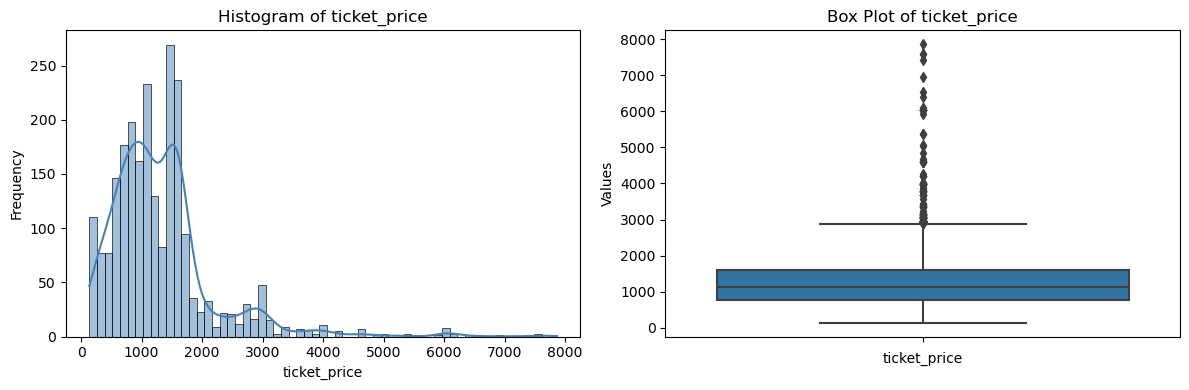

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram for ticket_price
sns.histplot(df_flight['ticket_price'], kde=True, color='steelblue', ax=axes[0])
axes[0].set_title('Histogram of ticket_price')
axes[0].set_xlabel('ticket_price')
axes[0].set_ylabel('Frequency')

# Boxplot for ticket_price
sns.boxplot(y=df_flight['ticket_price'], ax=axes[1])
axes[1].set_title('Box Plot of ticket_price')
axes[1].set_xlabel('ticket_price')
axes[1].set_ylabel('Values')

plt.tight_layout()
plt.show()

The response variable in our analysis is 'ticket_price'. Observations from its histogram plot reveal that its univariate distribution is generally unimodal but highly right-skewed, with a mean of 1316 and a median of 1128. Most samples are observed below the 3000 threshold. However, there are also some particularly expensive flights, suggesting that certain factors within our dataset may be associated with these high costs. The boxplot more clearly illustrates the potential extreme values (high prices) in our target variable. There are also very cheap flights, with some ticket prices as low as 135.


### Examine Predictors

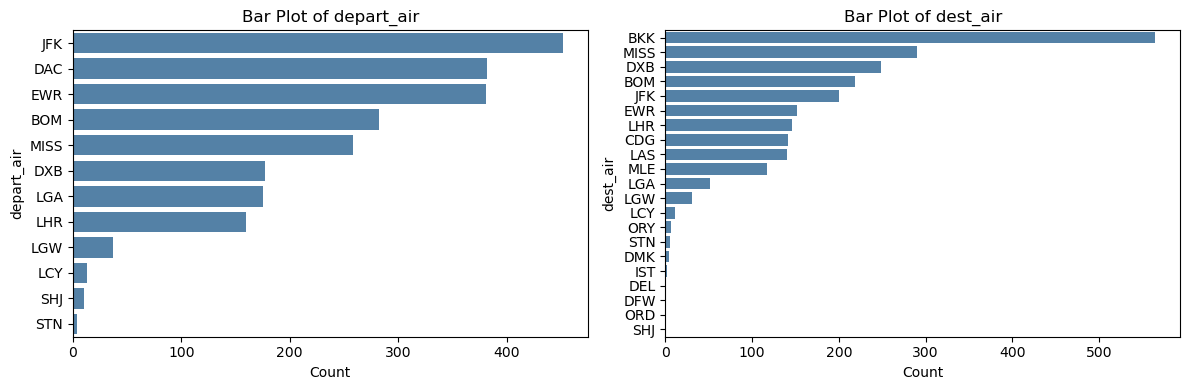

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Countplot for depart_air
sns.countplot(y=df_flight['depart_air'], order=df_flight['depart_air'].value_counts().index,
              color='steelblue', ax=axes[0])
axes[0].set_title('Bar Plot of depart_air')
axes[0].set_ylabel('depart_air')
axes[0].set_xlabel('Count')

# Countplot for dest_air
sns.countplot(y=df_flight['dest_air'], order=df_flight['dest_air'].value_counts().index,
              color='steelblue', ax=axes[1])
axes[1].set_title('Bar Plot of dest_air')
axes[1].set_ylabel('dest_air')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

From the bar plots, it is observed that John F. Kennedy International Airport (JFK) is the most common departure location for flights, followed by Hazrat Shahjalal International Airport (DAC) and Newark Liberty International Airport (EWR). Conversely, the most common destination for flights is Bangkok International Airport (BKK), which leads by a significant margin in terms of frequency compared to the second and third most common destinations.


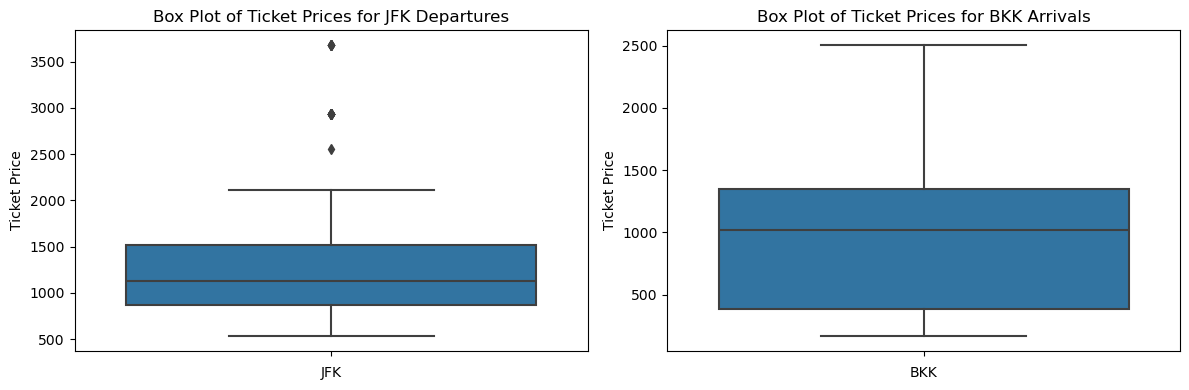

In [ ]:
# Filtering data for flights departing from 'JFK' and 'BKK'
jfk_prices = df_flight[df_flight['depart_air'] == 'JFK']['ticket_price']
bkk_prices = df_flight[df_flight['dest_air'] == 'BKK']['ticket_price']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot for flights departing from JFK
sns.boxplot(y=jfk_prices, ax=axes[0])
axes[0].set_title('Box Plot of Ticket Prices for JFK Departures')
axes[0].set_xlabel('JFK')
axes[0].set_ylabel('Ticket Price')

# Boxplot for flights arriving at BKK
sns.boxplot(y=bkk_prices, ax=axes[1])
axes[1].set_title('Box Plot of Ticket Prices for BKK Arrivals')
axes[1].set_xlabel('BKK')
axes[1].set_ylabel('Ticket Price')

plt.tight_layout()
plt.show()

The boxplots display the distribution of ticket prices for flights departing from JFK airport and those arriving at BKK airport. In both cases, most of the data is clustered around ticket prices ranging from $500 to $2000. However, the minimum ticket price and the median are higher for flights departing from JFK airport. Additionally, some outliers, representing high prices, are observed for tickets where the departure airport is JFK. Therefore, it can be inferred that ticket prices tend to be more expensive when the flight departs from JFK.

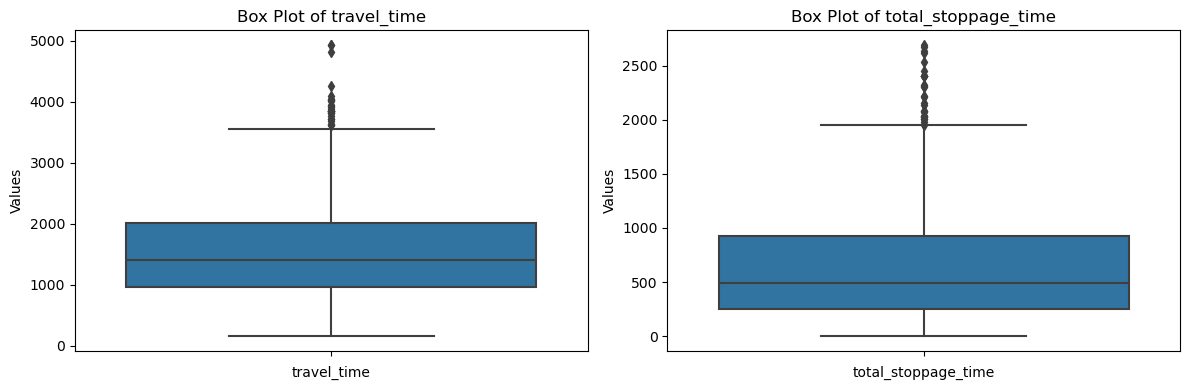

In [ ]:
# Create a new DataFrame with total_stoppage_time
total_stoppage_time = df_flight['1_stop_wait'] + df_flight['2_stop_wait'] + df_flight['3_stop_wait']
df_total_stoppage_time = pd.DataFrame({'total_stoppage_time': total_stoppage_time})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot for travel_time
sns.boxplot(y=df_flight['travel_time'], ax=axes[0])
axes[0].set_title('Box Plot of travel_time')
axes[0].set_xlabel('travel_time')
axes[0].set_ylabel('Values')

# Boxplot for total_stoppage_time
sns.boxplot(y=df_total_stoppage_time['total_stoppage_time'], ax=axes[1])
axes[1].set_title('Box Plot of total_stoppage_time')
axes[1].set_xlabel('total_stoppage_time')
axes[1].set_ylabel('Values')

plt.tight_layout()
plt.show()

The distributions of travel time and total stoppage time are highly skewed to the right, featuring outliers with exceptionally high values. Additionally, these two variables exhibit a much broader range compared to other numerical variables such as 'num_stop'. This disparity suggests that scaling these data before applying models like PCA or regression with regularization could be beneficial, since it helps ensure that variables with larger ranges don't disproportionately influence the model.

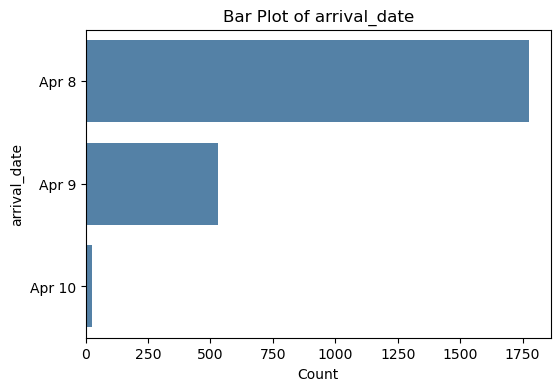

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(y=df_flight['arrival_date'], order=df_flight['arrival_date'].value_counts().index, color='steelblue')
plt.title(f'Bar Plot of arrival_date')
plt.ylabel('arrival_date')
plt.xlabel('Count')
plt.show()

The bar plot above reveals that over half of the observations have April 8 as the ‘arrival_date’. To address this imbalance, it might be beneficial to experiment with resampling techniques and to explore models with varying sensitivities to class imbalance. Later, we should try to understand the extent to which this imbalance impacts price predictions.

## Correlation Plot

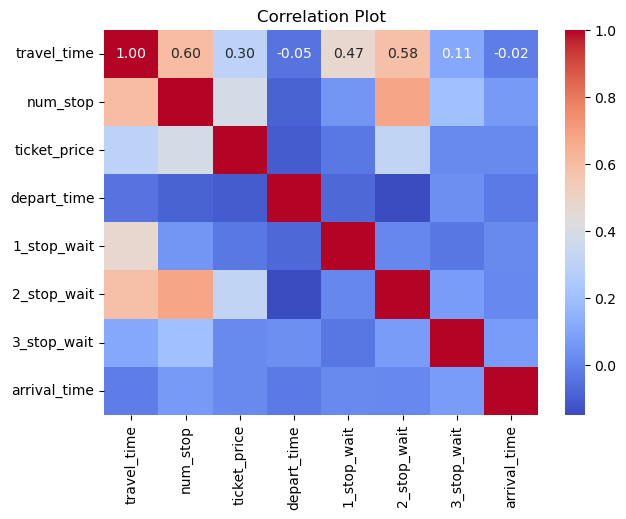

In [ ]:
corr = df_flight.corr(numeric_only=True)
plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation Plot')
plt.show()

Based on the correlation plot, it is evident that none of the numerical predictors individually exhibit a strong correlation with the response variable, ‘ticket_price’. Additionally, the likelihood of multicollinearity among most predictors seems low, as the majority display correlation coefficients below or around 0.7. A notable exception is the correlation between ‘total_stoppage_time’ and ‘1_stop_wait’, which has a high coefficient of 0.81. This is expected, considering that ‘total_stoppage_time’ is calculated as the sum of wait times for all stops.Consequently, when using regression models,we might consider excluding the wait times for single stops to avoid redundancy and potential multicollinearity issues.

## PCA Preview

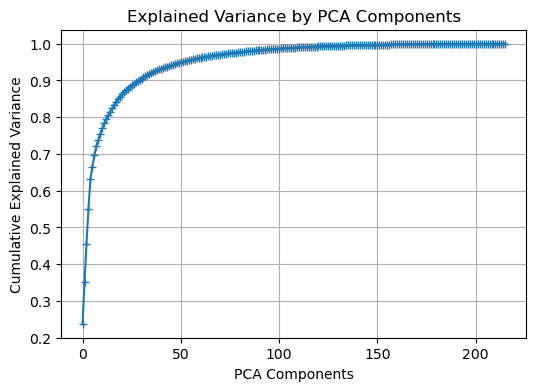

In [ ]:
X_data = df_flight.drop(columns=['ticket_price'])

def PCA_preprocess_simple(X_data):
  # Identify numerical and categorical features
  numerical_cols = X_data.select_dtypes(include=['int64', 'float64']).columns
  categorical_cols = X_data.select_dtypes(include=['object']).columns

  # Standardize numerical predictors
  scaler = StandardScaler()
  X_data_num = scaler.fit_transform(X_data[numerical_cols])

  # One-hot encode categorical predictors
  encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
  encoder.fit(X_data[categorical_cols])
  X_data_cat = encoder.transform(X_data[categorical_cols]).toarray()

  # Combine scaled numerical data and encoded categorical data
  X_data_prep = np.hstack([X_data_num, X_data_cat])

  return X_data_prep

# Preprocess data
X_data_prep = PCA_preprocess_simple(X_data)

# Apply PCA
pca_preview = PCA()
X_data_pca = pca_preview.fit_transform(X_data_prep)

# Calculate the cumulative variance ratio
cumulative_variance_ratio = pca_preview.explained_variance_ratio_.cumsum()

# Plot the variance ratio explained by each PC
plt.figure(figsize=(6, 4))
plt.plot(cumulative_variance_ratio, marker='+')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

The plot above shows the cumulative explained variance as we move along the principal components. We can observe that the first 10 principal components already explain a substantial amount of the variance in the data. This allows us to extract components that end up less than the number of the original features and still end up retaining most of the variance.

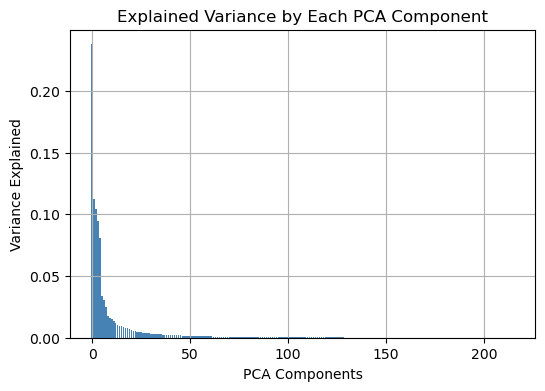

In [ ]:
# histogram for the PCA components' variance
plt.figure(figsize=(6, 4))
plt.bar(range(len(pca_preview.explained_variance_ratio_)), pca_preview.explained_variance_ratio_, color='steelblue')
plt.xlabel('PCA Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Each PCA Component')
plt.grid(True)
plt.show()

In [ ]:
n_components_80 = (cumulative_variance_ratio < 0.95).sum() + 1
print(f'The variance of the first {n_components_80} Principal Components explained 80% of Data.')

The variance of the first 52 Principal Components explained 80% of Data.


We conducted a preliminary PCA that fits the entire dataset. From the bar plot, we observed a steep drop in explained variance after the first 10 principal components. This indicates that the first 10 principal components could explain most of the information in the dataset, making it a desirable candidate for PCA implementation. Precisely, according to the first figure, the first 14 principal components explained about 80% of the data. This is a significant reduction from the more than 216 predictors in total after one-hot encoding.


# Prepare and Preprocess Data for Modeling

## Split data into train/test sets

In [ ]:
# split into train test split
flight_df = pd.read_csv('flight_cleaned.csv')
X_data = flight_df.drop(columns=['ticket_price'])
y_data = flight_df['ticket_price']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)

## Standaize numerical predictors and encode categorical predictors

In [ ]:
X_train_prep, X_test_prep, encoder, categorical_cols, numerical_cols = data_preprocess(flight_df, X_train, X_test)

In [ ]:

categories = encoder.categories_
new_categorical_features = [f"{col}_{cat}" for col, cats in zip(categorical_cols, categories) for cat in cats[1:]]
all_features = list(numerical_cols) + new_categorical_features


# Modeling Flowchart

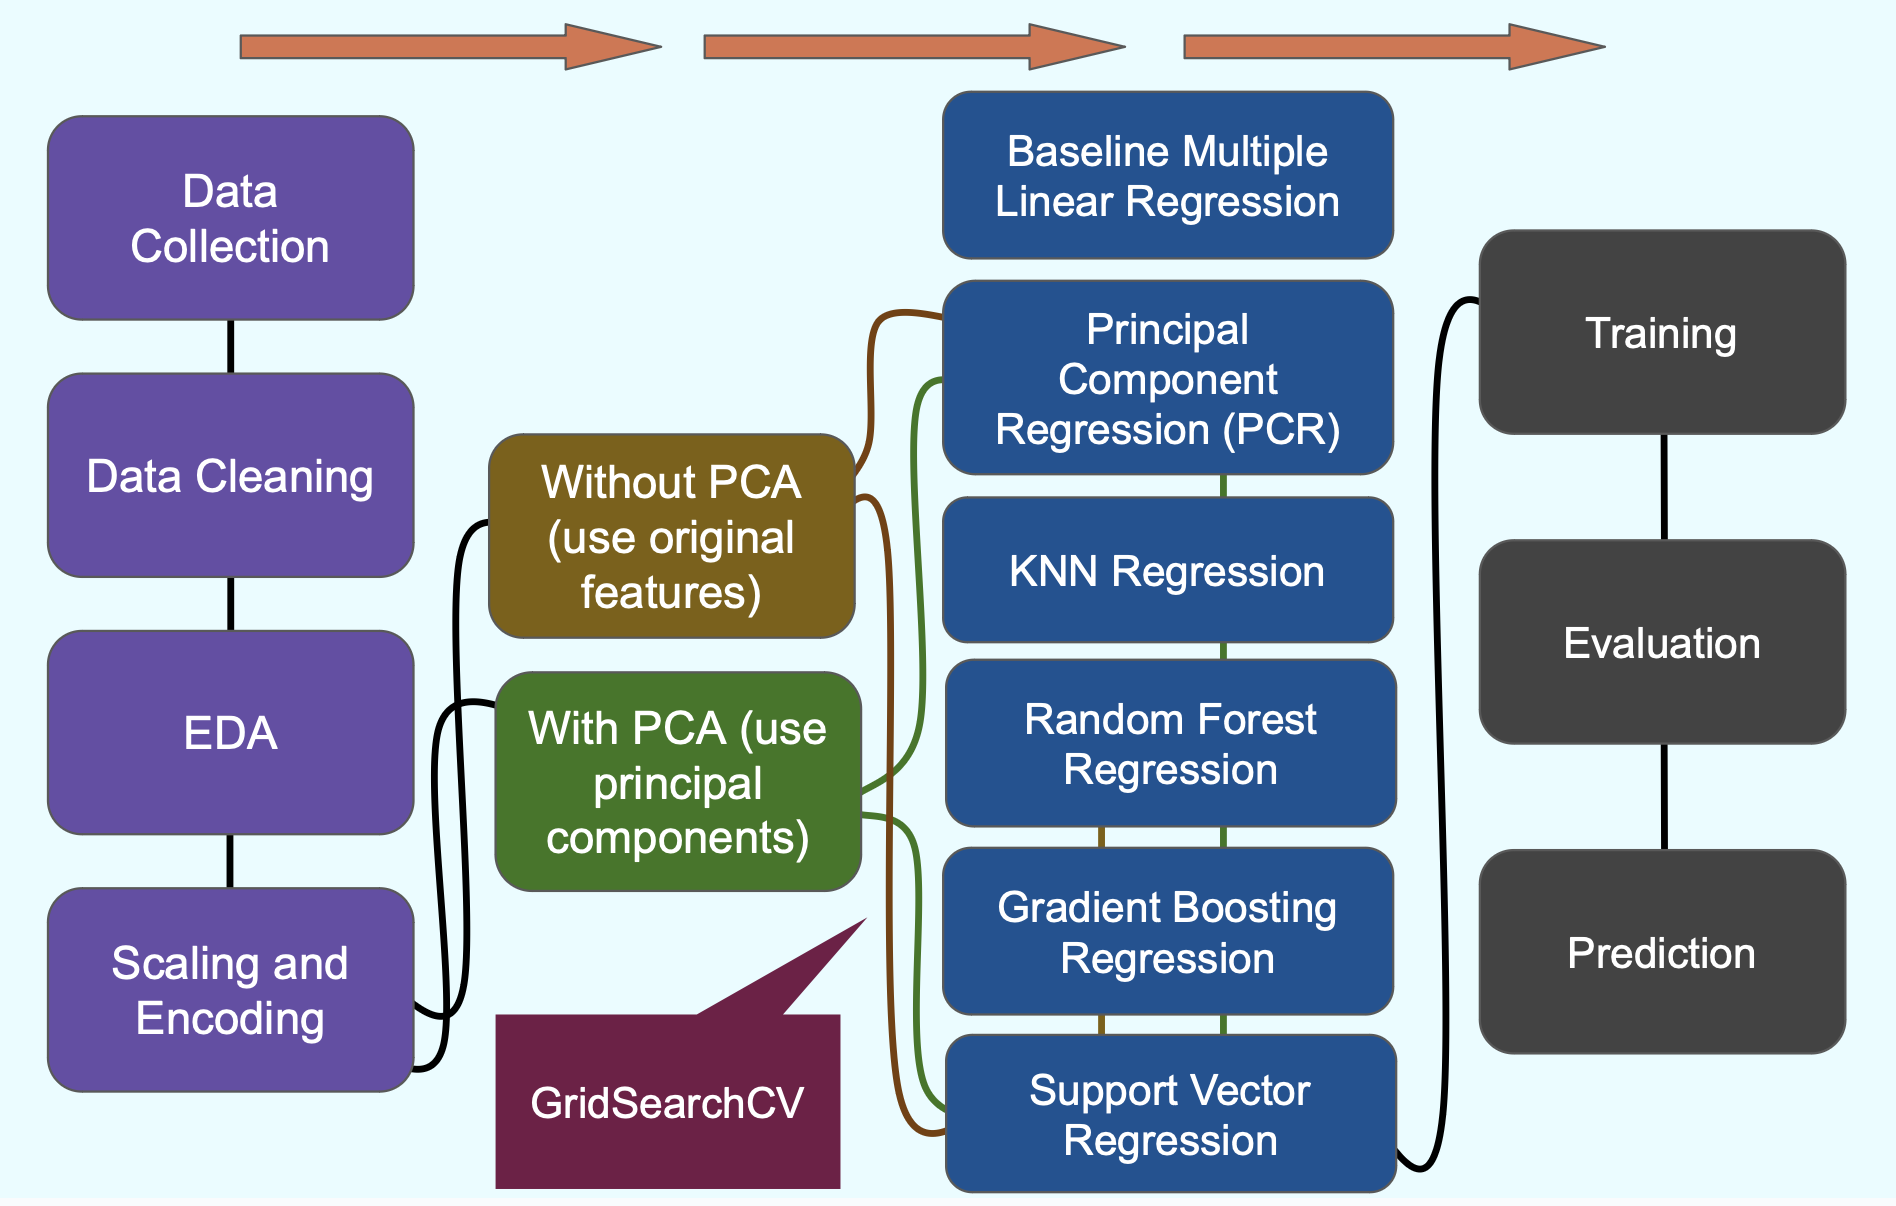


#Baseline Model: Multiple Linear Regression

## Baseline model training

In [ ]:
linreg = LinearRegression().fit(X_train_prep, y_train)

# Calculate R^2 values
lr_train_r2 = linreg.score(X_train_prep, y_train)
lr_test_r2 = linreg.score(X_test_prep, y_test)

# Predictions
y_train_predict = linreg.predict(X_train_prep)
y_test_predict = linreg.predict(X_test_prep)

# Calculate Mean Squared Error (MSE)
lr_train_mse = mean_squared_error(y_train, y_train_predict)
lr_test_mse = mean_squared_error(y_test, y_test_predict)


results_dict = {'R^2': [lr_train_r2, lr_test_r2], 'MSE': [lr_train_mse, lr_test_mse]}
results_df = pd.DataFrame(data=results_dict, index=['Train', 'Test'])
display(results_df)


,R^2,MSE
Train,7.131139e-01,2.184866e+05
Test,-3.281324e+18,2.816610e+24


## Intepretation


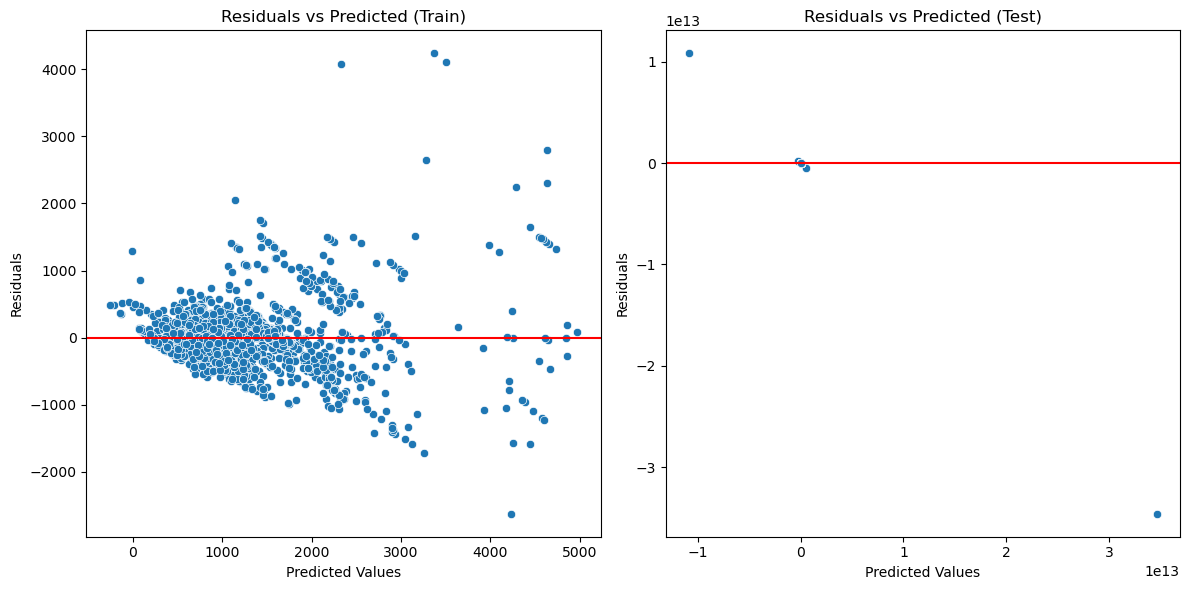

In [ ]:
train_residuals = y_train - y_train_predict
test_residuals = y_test - y_test_predict

# Plotting the residuals
plt.figure(figsize=(12, 6))

# Train residuals
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_predict, y=train_residuals)
plt.title('Residuals vs Predicted (Train)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')

# Test residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_predict, y=test_residuals)
plt.title('Residuals vs Predicted (Test)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')

plt.tight_layout()
plt.show()


Based on the residual plots for the training set, there is a noticeable trend where the magnitude of the residuals increases as the predicted values increase, indicating the presence of heteroscedasticity. This pattern, where the variance of the residuals expands with larger predicted values, suggests that a linear regression model might not be the best option for our flight data.
For the testing set, the presence of a few extremely large magnitude residuals is particularly concerning. These outliers in the residuals could be indicative of specific instances where the model's predictions are significantly off-mark, which could arise from anomalies or unique characteristics in the test data that the model, trained on the training set, is not equipped to handle. These large residuals can significantly impact the model's overall accuracy. The plot below shows the residual plot for testing set after removing the extreme values (outliers)

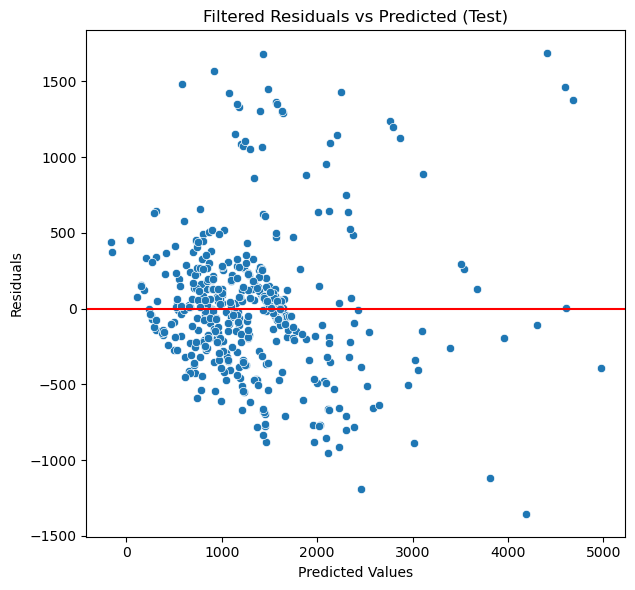

In [ ]:
# Filter out the outliers
lower_quantile_test = np.percentile(test_residuals, 1)
upper_quantile_test = np.percentile(test_residuals, 99)
test_residuals_filtered = test_residuals[(test_residuals > lower_quantile_test) & (test_residuals < upper_quantile_test)]
y_test_predict_filtered = y_test_predict[(test_residuals > lower_quantile_test) & (test_residuals < upper_quantile_test)]

# Replotting the residuals
plt.figure(figsize=(12, 6))

# Test residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_predict_filtered, y=test_residuals_filtered)
plt.title('Filtered Residuals vs Predicted (Test)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')

plt.tight_layout()
plt.show()

This residual plot is for the testing set after removing outliers (residuals the magnitude outside of 1th and 99th percentile range). We can tell that the variance of residuals also increases with the increase of predicted values, which could be sign of heteroscedasticity

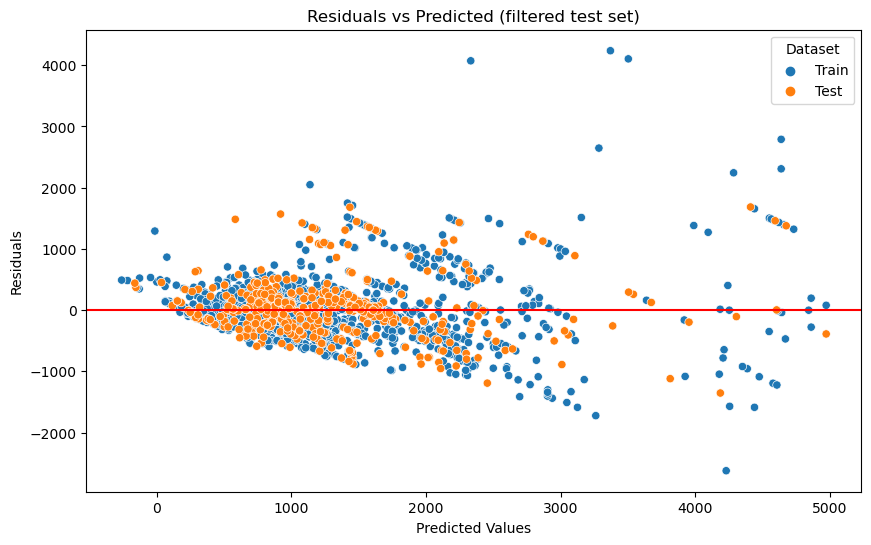

In [ ]:
train_df = pd.DataFrame({
    'Predictions': y_train_predict,
    'Residuals': train_residuals,
    'Set': 'Train'
})

test_df = pd.DataFrame({
    'Predictions': y_test_predict_filtered,
    'Residuals': test_residuals_filtered,
    'Set': 'Test'
})

# Combining the DataFrames
combined_df = pd.concat([train_df, test_df])


# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='Predictions', y='Residuals', hue='Set')
plt.title('Residuals vs Predicted (filtered test set)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend(title='Dataset')
plt.show()



After removing outliers from test set that fell below the 1st percentile or above the 99th percentile, the residual analysis reveals similar issues in both the training and testing sets: the variance of redisuals increase with predicted values, which indicates the issues of heteroscedasticity and the model's inability to capture complex, nonlinear relationships in the data. The presence of these issues in both sets suggests the need for considering non-linear approaches or a more robust treatment of variable interactions to improve predictive performance and better handle the dataset's intricacies.

In [ ]:
# Feature Importance Analysis
# For linear models, coefficients represent the feature importance
feature_names = np.concatenate([numerical_cols, encoder.get_feature_names_out(categorical_cols)])
coefficients = linreg.coef_

# Create a DataFrame for easier visualization
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)


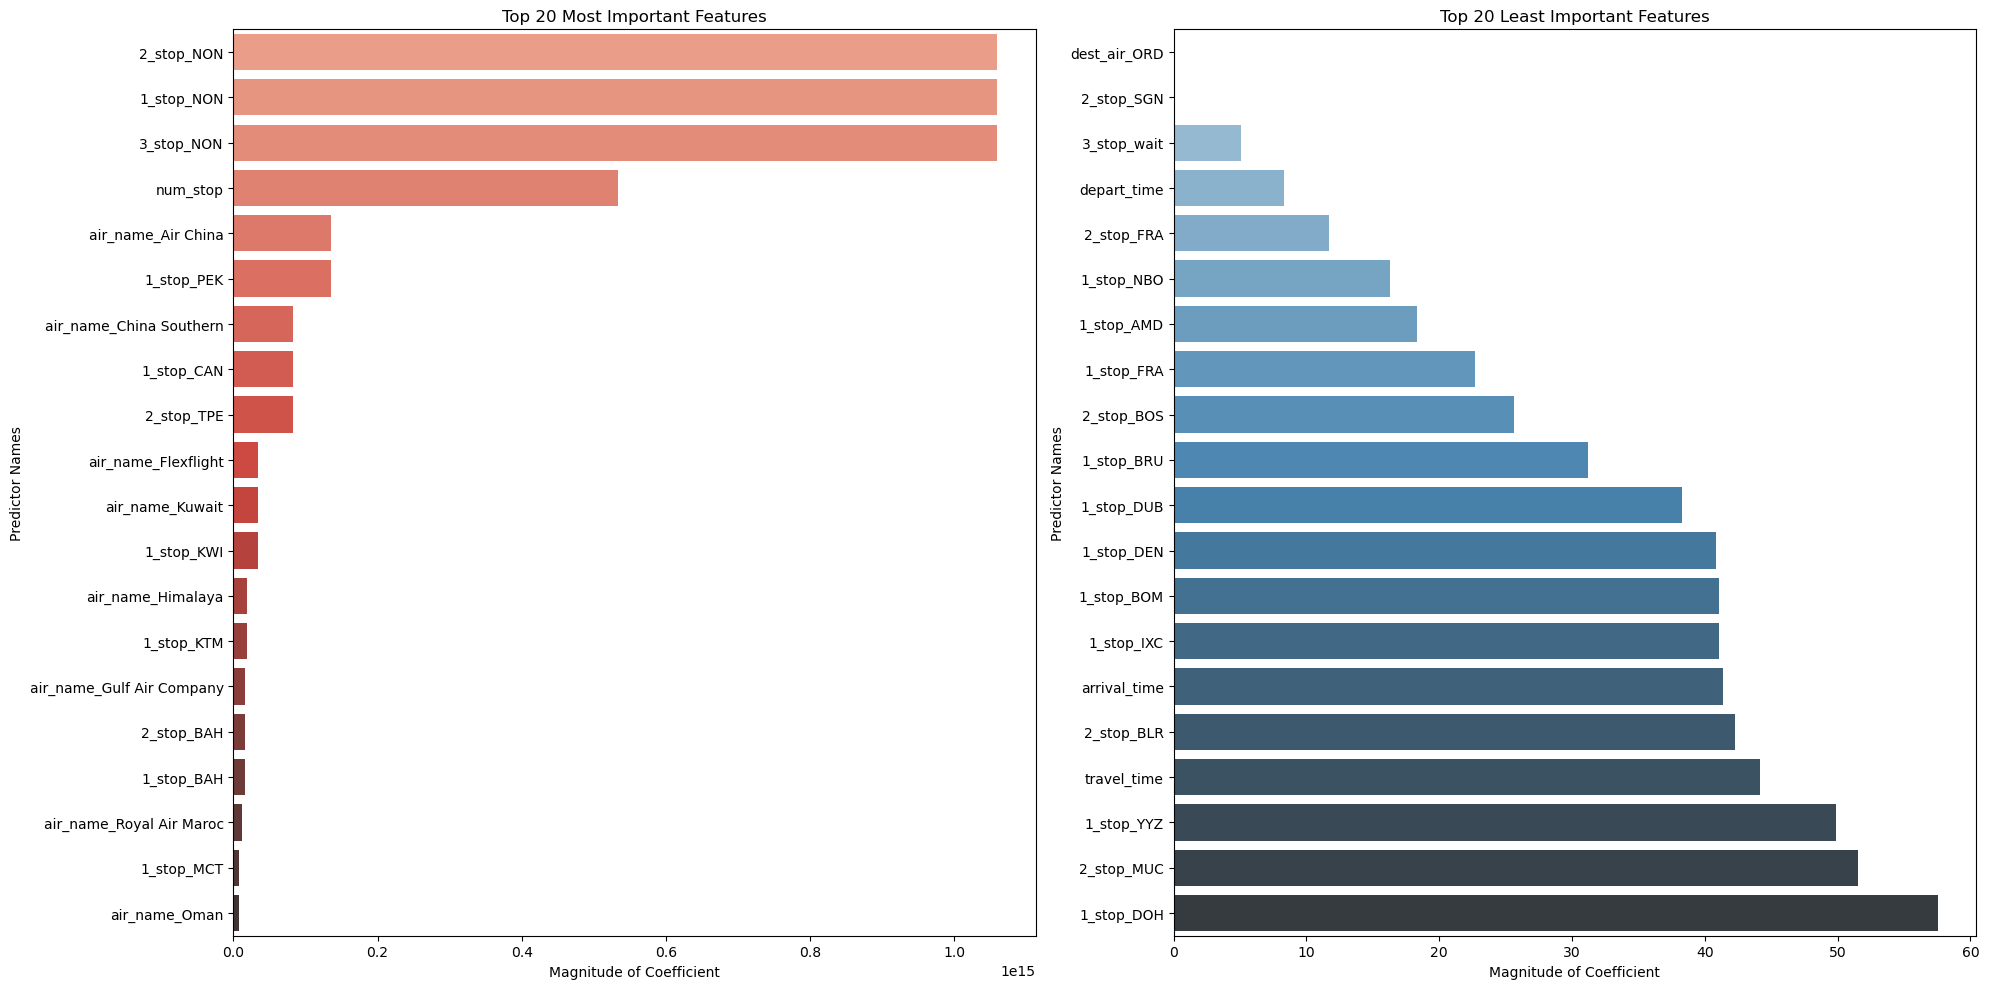

In [ ]:
coef_df['abs_coef'] = coef_df['Coefficient'].abs()

# Sort features by the absolute values of their coefficients
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

# Select top 20 most important features (largest absolute coefficients)
top_features_df = coef_df.head(20)


# Select top 20 least important features (smallest absolute coefficients)
le_features_df = coef_df.nsmallest(20, 'abs_coef')

# Plotting
plt.figure(figsize=(20, 10))

# Top 20 Most Important Features
plt.subplot(1, 2, 1)
sns.barplot(x='abs_coef', y='Feature', data=top_features_df, palette="Reds_d")
plt.title('Top 20 Most Important Features')
plt.xlabel('Magnitude of Coefficient')
plt.ylabel('Predictor Names')

# Top 20 Least Important Features
plt.subplot(1, 2, 2)
sns.barplot(x='abs_coef', y='Feature', data=le_features_df, palette="Blues_d")
plt.title('Top 20 Least Important Features')
plt.xlabel('Magnitude of Coefficient')
plt.ylabel('Predictor Names')

plt.tight_layout()
plt.show()


In linear regression, the predictors with larger magnitudes of coefficients are considered more important. Based on our baseline model, the feature '2_stop_non' (indicating no 2 stops) emerges as the most significant predictor, with a coefficient of -1.606579e+14. This implies that the presence of '2_stop_non' would decrease the ticket price by approximately 1.606579e+14 units, assuming all other variables remain constant. On the other hand, the least influential predictor in our model is 'dest_air_ORD', which has a coefficient of 0. This indicates that the variable 'dest_air_ORD' does not significantly impact the prediction of ticket prices

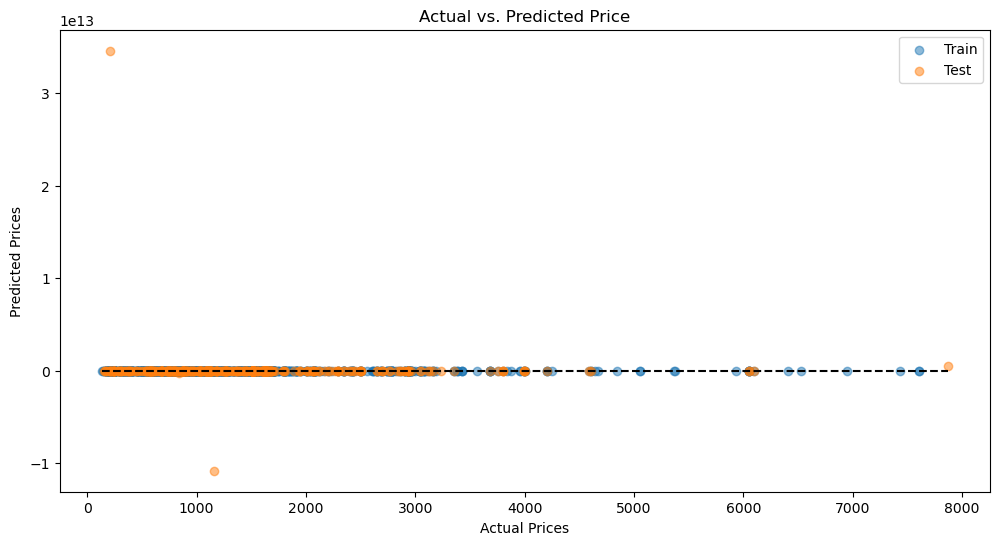

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_predict, alpha=0.5, label='Train')
plt.scatter(y_test, y_test_predict, alpha=0.5, label='Test')
plt.title('Actual vs. Predicted Price')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--')  # Diagonal line
plt.show()

Consistent with residuals plots, we have found that there are few predicted value points that are way off the mark from the atucal values.

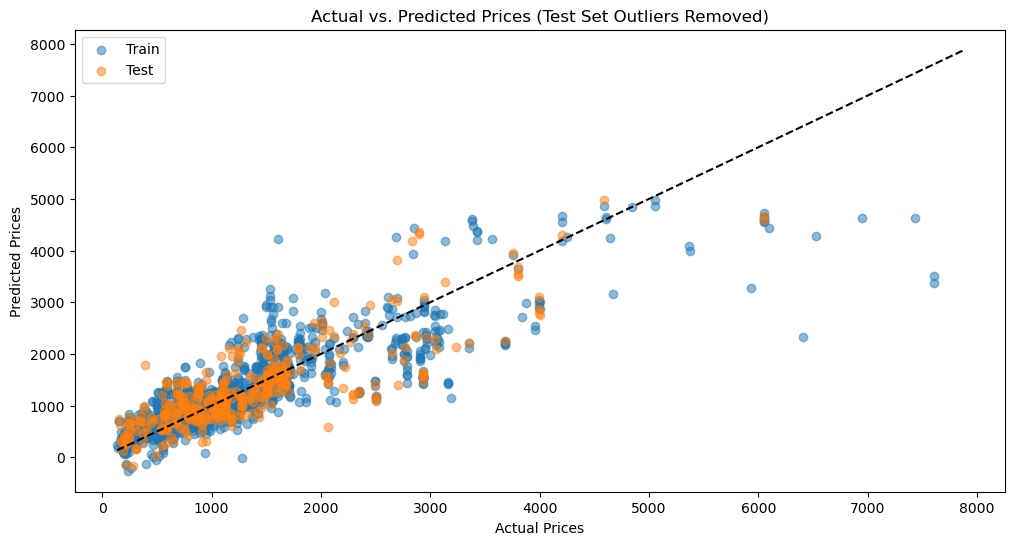

In [ ]:
test_diff = np.abs(y_test - y_test_predict)

# Determine the quantiles for filtering
lower_quantile_test = np.percentile(test_diff, 2)
upper_quantile_test = np.percentile(test_diff, 98)

# Filter out the outliers
test_filter = (test_diff > lower_quantile_test) & (test_diff < upper_quantile_test)

# Plotting without outliers
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_predict, alpha=0.5, label='Train')
plt.scatter(y_test[test_filter], y_test_predict[test_filter], alpha=0.5, label='Test')
plt.title('Actual vs. Predicted Prices (Test Set Outliers Removed)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--')  # Diagonal line
plt.show()

After removing the outliers, the plot of actual versus predicted values aligns closely with the diagonal line for smaller actual prices, yet increasingly deviates from this line as actual prices rise. This discrepancy indicates that, even with outliers excluded, the predicted values do not consistently correspond to the actual values, particularly at higher price ranges. Such a pattern suggests a limitation in the model's ability to accurately predict more costly tickets, possibly due to unaccounted variables or non-linear relationships not captured by the current linear model. This observation underscores the need for a more complex modeling approach, perhaps incorporating polynomial features or a different algorithm better suited for handling non-linearity.

In [ ]:
y_test_filtered = y_test[test_filter]
y_test_predict_filtered = y_test_predict[test_filter]
test_mse_filtered = mean_squared_error(y_test_filtered, y_test_predict_filtered)
test_r2_filtered = r2_score(y_test_filtered, y_test_predict_filtered)


# Update results_dict to include filtered results
results_dict = {
    'R^2': [lr_train_r2, lr_test_r2, test_r2_filtered],
    'MSE': [lr_train_mse, lr_test_mse, test_mse_filtered]
}

# Update DataFrame
results_df = pd.DataFrame(data=results_dict, index=['Train', 'Test', 'Test_Outliers_Filtered'])

# Display the DataFrame
display(results_df)

,R^2,MSE
Train,7.131139e-01,2.184866e+05
Test,-3.281324e+18,2.816610e+24
Test_Outliers_Filtered,6.834452e-01,2.206642e+05


After removing outliers from the test set, we observed a significant improvement in both the R² score and MSE, bringing them closer to the training set metrics. This improvement suggests that the model's initial performance was substantially affected by these outliers. However, issues still remain evident. The residual plots display persistent heteroscedasticity, and there's a notable discrepancy between actual and predicted prices, especially at higher price ranges. Moreover, the relatively modest R² scores further imply that our baseline linear regression model may not be fully adequate for predicting flight ticket prices. The data likely exhibits complex, non-linear patterns that are beyond the scope of a simple multiple linear regression model. Additionally, the model's large number of predictors signifies a high-dimensionality problem. To effectively tackle this, dimensionality reduction techniques such as Principal Component Analysis (PCA) should be considered. Implementing such methods can simplify the model and maintain critical information, potentially enhancing performance and yielding more accurate predictions. The huge difference between training and test in terms of both R^2 and MSE also signifies the issues of overfitting.

# PCA Data Preperation

In [ ]:
# Apply PCA on training sets
pca = PCA()
X_train_pca = pca.fit_transform(X_train_prep)
X_test_pca = pca.transform(X_test_prep)

# Calculate the cumulative variance ratio
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()



In [ ]:
n_components = (cumulative_variance_ratio < 0.90).sum() + 1
print(f'The variance of the first {n_components} Principal Components explained 90% of Data.')

The variance of the first 30 Principal Components explained 90% of Data.


In [ ]:
# fit the model using first 30 principle components
X_train_pca_reduced = X_train_pca[:, :n_components]
X_test_pca_reduced = X_test_pca[:, :n_components]

Text(0, 0.5, 'Ticket Price')

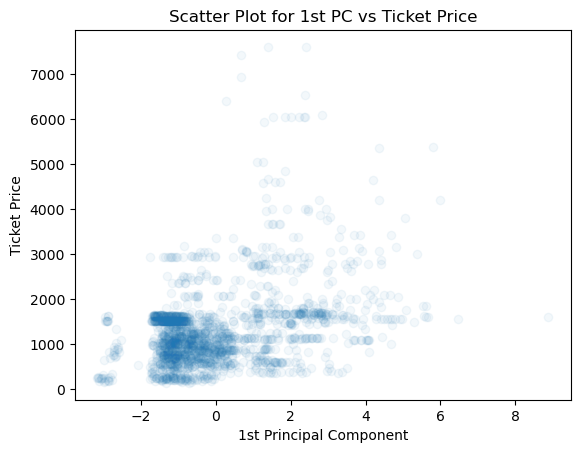

In [ ]:
plt.scatter(X_train_pca[:, 0:1], y_train, alpha=0.05)
plt.title('Scatter Plot for 1st PC vs Ticket Price')
plt.xlabel('1st Principal Component')
plt.ylabel('Ticket Price')

There appears to be a correlation between the first principal component and the ticket price, as most data points are concentrated at lower values of the first principal component. Additionally, the variance in ticket prices seems to increase with the increasing values of the first principal component.

# Model 1: Multiple Linear Regression with PCA (PCR)

## Motivation for Model Selection:

## PCR Model Training

In [ ]:
pcr_ridge_model = Ridge(max_iter=50000)
pcr_lasso_model = Lasso(max_iter=50000)

# Define parameter grid for tuning
pcr_ridge_param_grid = {
    'alpha' : [0.0, 0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 40.0, 100.0],
    'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
pcr_lasso_param_grid = {
    'alpha' : [0.0, 0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 40.0, 100.0]
}

# Perform Hyperparameter Tuning
best_pcr_ridge, best_pcr_ridge_params = hyperparameter_tuning(pcr_ridge_model, pcr_ridge_param_grid, X_train_pca_reduced, y_train)
best_pcr_lasso, best_pcr_lasso_params = hyperparameter_tuning(pcr_lasso_model, pcr_lasso_param_grid, X_train_pca_reduced, y_train)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
Best Hyperparameters: {'alpha': 5.0, 'solver': 'auto'}
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Hyperparameters: {'alpha': 1.0}


In [ ]:
# Fit and evaluate the model
pcr_ridge_fitted, pcr_ridge_train_r2, pcr_ridge_test_r2, pcr_ridge_train_mse, pcr_ridge_test_mse, pcr_ridge_training_time = fit_and_evaluate_model(best_pcr_ridge.best_estimator_, X_train_pca_reduced, y_train, X_test_pca_reduced, y_test)
pcr_lasso_fitted, pcr_lasso_train_r2, pcr_lasso_test_r2, pcr_lasso_train_mse, pcr_lasso_test_mse, pcr_lasso_training_time = fit_and_evaluate_model(best_pcr_lasso.best_estimator_, X_train_pca_reduced, y_train, X_test_pca_reduced, y_test)

# Print the results
print(f"Rridge Training R²: {pcr_ridge_train_r2}")
print(f"Rridge Test R²: {pcr_ridge_test_r2}")
print(f"Rridge Training MSE: {pcr_ridge_train_mse}")
print(f"Rridge Test MSE: {pcr_ridge_test_mse}")
print("\n")
print(f"Lasso Training R²: {pcr_lasso_train_r2}")
print(f"Lasso Test R²: {pcr_lasso_test_r2}")
print(f"Lasso Training MSE: {pcr_lasso_train_mse}")
print(f"Lasso Test MSE: {pcr_lasso_test_mse}")

Rridge Training R²: 0.45201495609905973
Rridge Test R²: 0.45751040156576994
Rridge Training MSE: 417334.18956366484
Rridge Test MSE: 465660.0796291042


Lasso Training R²: 0.45183440759498394
Lasso Test R²: 0.45719075917639784
Lasso Training MSE: 417471.69160767866
Lasso Test MSE: 465934.4530012711


In [ ]:
# display and compare the results from KNN and baseline model
model_df = display_results("Baseline: Multiple Linear Regression", train_mse = lr_train_mse, test_mse = lr_test_mse, train_r2 = lr_train_r2, test_r2 = lr_test_r2, training_time = None)
model_df = display_results("PCR Ridge", train_mse = pcr_ridge_train_mse, test_mse = pcr_ridge_test_mse, train_r2 = pcr_ridge_train_r2, test_r2 = pcr_ridge_test_r2, training_time = pcr_ridge_training_time, results_df=model_df)
model_df = display_results("PCR Lasso", train_mse = pcr_lasso_train_mse, test_mse = pcr_lasso_test_mse, train_r2 = pcr_lasso_train_r2, test_r2 = pcr_lasso_test_r2, training_time = pcr_lasso_training_time, results_df=model_df)
display(model_df)

c:\Users\yuant\OneDrive\Desktop\ac209a_m5\utils.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, cur_results_df], ignore_index=True)


,Model,Train_R^2,Test_R^2,Train_MSE,Test_MSE,Training Time
0,Baseline: Multiple Linear Regression,0.713114,-3.281324e+18,218486.564344,2.816610e+24,NaN
1,PCR Ridge,0.452015,4.575104e-01,417334.189564,4.656601e+05,0.001997
2,PCR Lasso,0.451834,4.571908e-01,417471.691608,4.659345e+05,0.001007


## Intepretation and Key Takeaways

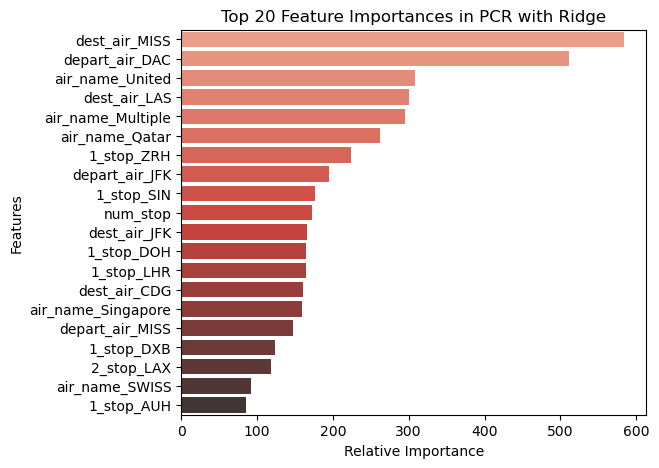

In [ ]:
pcr_ridge_reverted_feature_importance = get_original_feature_importances(model = pcr_ridge_fitted, pca = pca, original_features = all_features, n_components=n_components)
pcr_ridge_feature_names = [item[0] for item in pcr_ridge_reverted_feature_importance]
pcr_ridge_feature_importances = [item[1] for item in  pcr_ridge_reverted_feature_importance]
plot_top_feature_importance(model_name="PCR with Ridge", feature_importance = pcr_ridge_feature_importances, num_features_to_display = 20 , feature_names = pcr_ridge_feature_names)

The PCR with Ridge identifies dest_air_MISS'(the one-hot encoded categorical variable for the destination airport being MISS)', 'air_name_United'(the one-hot encoded categorical variable for airline being United) as the most important features, which suggests the importance of destination and departure airport and airlines for ticket price predictions.

## PCR Reverse Engineering

In order to get the feature importances for the original variables (this applies to all the subsequent models in this project where PCA is used), we define a helper function which implements the following steps:

* Get feature importances from the model (based on PCA components)

* Get PCA loadings (contribution of each original feature to the PCA components)

* Multiply the contribution of each original feature by the importance of each PCA component

* Aggregate the results across all PCA components for each original feature

* Sort the results


The horizontal bar plot above is the result of applying these steps for PCR with Ridge.

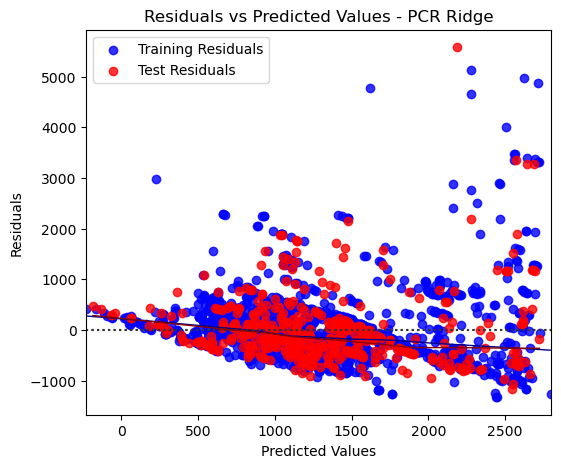

In [ ]:
# Residual Plot
plot_residuals(model = pcr_ridge_fitted,model_name = "PCR Ridge", X_train = X_train_pca_reduced, y_train = y_train, X_test = X_test_pca_reduced, y_test = y_test)

The variance of residuals seems to increases with predicted values, which indicates heteroscedasticity.

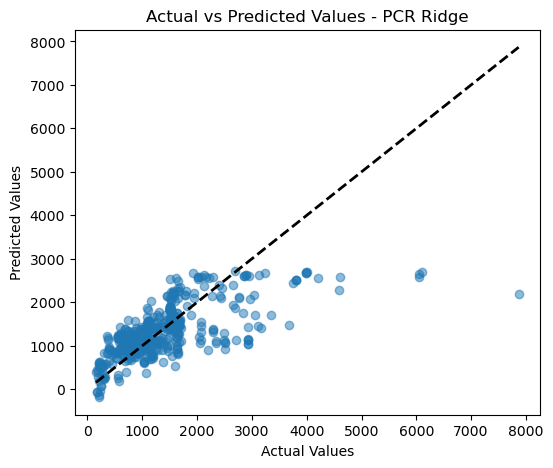

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(pcr_ridge_fitted,"PCR Ridge", X_test_pca_reduced, y_test)

The actual and precited tickets prices align relatively well at lower price range, but starts to deviate at higher price range, indicating potential limitations of the model in accurately predicting prices across all ranges.

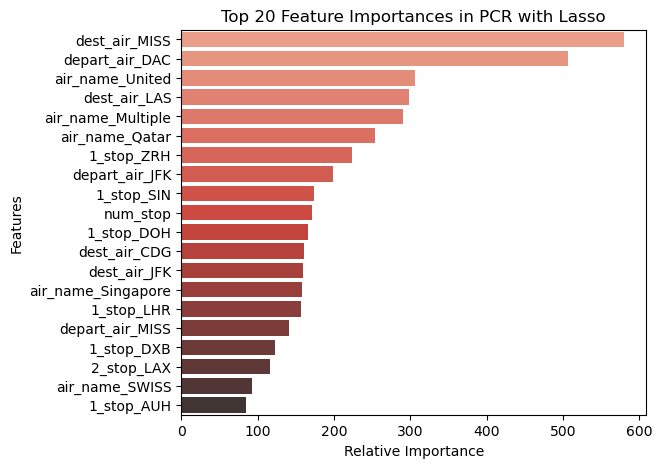

In [ ]:
pcr_lasso_reverted_feature_importance = get_original_feature_importances(model = pcr_lasso_fitted, pca = pca, original_features = all_features, n_components=n_components)
pcr_lasso_feature_names = [item[0] for item in pcr_lasso_reverted_feature_importance]
pcr_lasso_feature_importances = [item[1] for item in  pcr_lasso_reverted_feature_importance]
plot_top_feature_importance(model_name="PCR with Lasso", feature_importance = pcr_lasso_feature_importances, num_features_to_display = 20 , feature_names = pcr_lasso_feature_names)

By comparing the above bar plot with the first bar plot (Feature Importances in PCR with Ridge), we can observe that most of the top important features for PCR with Lasso align one to one with those for PCR with Ridge.

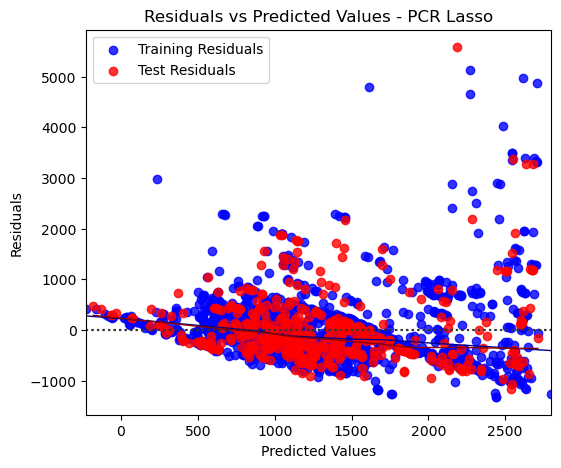

In [ ]:
# Residual Plot
plot_residuals(model = pcr_lasso_fitted,model_name = "PCR Lasso", X_train = X_train_pca_reduced, y_train = y_train, X_test = X_test_pca_reduced, y_test = y_test)

Similiar to the ridge residual plot, the variance of residuals seems to increases with predicted values, which indicates heteroscedasticity.

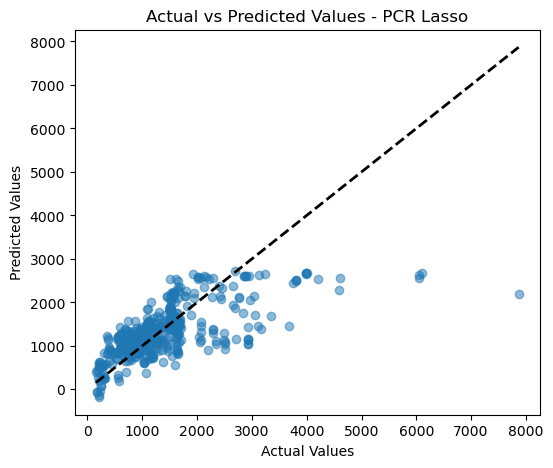

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(pcr_lasso_fitted,"PCR Lasso", X_test_pca_reduced, y_test)

Also similiar to ridge case, the actual and precited tickets prices deviate more and more at higher price range, indicating potential limitations of the model in accurately predicting prices across all ranges.

# Model 2: KNN Regression with PCA

## Motivation for Model Selection
The first model we decided to experienment with is KNNregression with PCA. There are a number of reasons that leads to such selection:

* KNN is a non-parametric method, making it inherently suitable for capturing non-linear relationships between variables. Since our observations from data and baseline model suggest that the data exhibits complex, non-linear patterns, KNN can be more adept at modeling these intricacies compared to linear regression.

* PCA can help in reducing the high dimensionality of our flight data. By transforming the features into principal components, PCA retains the most significant variance in the data with fewer dimensions. This reduction in dimensionality can make KNN more effective, as KNN suffers from the curse of dimensionality in high-dimensional spaces. Moreover, PCA can help in removing noise and redundant information from the dataset, potentially leading to better model accuracy.


* KNN makes predictions based on localized data points (nearest neighbors). This approach can be particularly useful in scenarios like flight ticket pricing where prices may be influenced by localized factors or patterns that a global model like linear regression may overlook.



## KNN Model Training

In [ ]:
knn_model = KNeighborsRegressor()

# Define parameter grid for tuning
knn_param_grid = {
    'n_neighbors': [1, 2, 3, 5, 7, 9, 15, 30, 50, 100],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Perform Hyperparameter Tuning
best_knn, best_knn_params = hyperparameter_tuning(knn_model, knn_param_grid, X_train_pca_reduced, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'distance'}


In [ ]:
# Fit and evaluate the model
knn_fitted, knn_train_r2, knn_test_r2, knn_train_mse, knn_test_mse, knn_training_time = fit_and_evaluate_model(best_knn.best_estimator_, X_train_pca_reduced, y_train, X_test_pca_reduced, y_test)

# Print the results
print(f"KNN Training R²: {knn_train_r2}")
print(f"KNN Test R²: {knn_test_r2}")
print(f"KNN Training MSE: {knn_train_mse}")
print(f"KNN Test MSE: {knn_test_mse}")

KNN Training R²: 0.9966796309907235
KNN Test R²: 0.6293261977366621
KNN Training MSE: 2528.7250536516185
KNN Test MSE: 318177.51488058304


## Model Intepretation

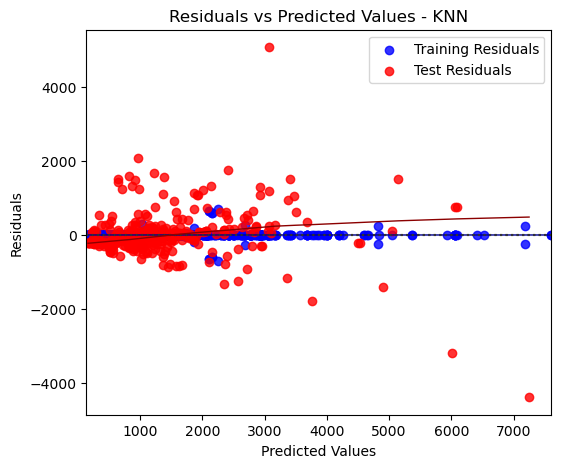

In [ ]:
# Residual Plot
plot_residuals(model = knn_fitted,model_name = "KNN", X_train = X_train_pca_reduced, y_train = y_train, X_test = X_test_pca_reduced, y_test = y_test)

In the KNN model with PCA, the training residuals are relatively small and closely aligned with the horizontal axis, indicating no apparent residual patterns, which suggests a good fit on the training data. However, the residuals for the testing set are of much greater magnitude compared to those of the training set. Moreover, the test residuals exhibit a discernible pattern: the variance of the residuals increases with the predicted values. This pattern indicates potential risks of overfitting and a model's inability to generalize well to new, unseen data. Such heteroscedasticity also points towards the limitations of the model in consistently capturing complex relationships across different segments of the data.

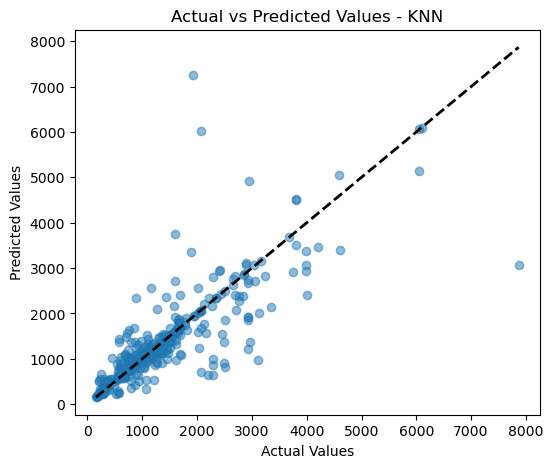

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(knn_fitted,"KNN", X_test_pca_reduced, y_test)

In the testing set, the alignment between predicted and actual values is quite accurate in the lower left region, suggesting effective prediction for lower flight ticket prices. However, as the flight ticket prices increase, a noticeable deviation between predicted and actual values emerges. This divergence at higher price ranges again indicates the KNN model's limited capability in accurately capturing complex relationships across different data segments, particularly for higher-priced tickets. This pattern underscores the model's challenges in generalizing to the full range of the dataset, especially in more complex or higher-value scenarios

## Summary and Key Takeaways

In [ ]:
# display and compare the results from KNN and baseline model
model_df = display_results("KNN", train_mse = knn_train_mse, test_mse = knn_test_mse, train_r2 = knn_train_r2, test_r2 = knn_test_r2, training_time = knn_training_time, results_df=model_df)
display(model_df)

,Model,Train_R^2,Test_R^2,Train_MSE,Test_MSE,Training Time
0,Baseline: Multiple Linear Regression,0.713114,-3.281324e+18,218486.564344,2.816610e+24,NaN
1,PCR Ridge,0.452015,4.575104e-01,417334.189564,4.656601e+05,0.001997
2,PCR Lasso,0.451834,4.571908e-01,417471.691608,4.659345e+05,0.001007
3,KNN,0.996680,6.293262e-01,2528.725054,3.181775e+05,0.000998


In the KNN model with PCA, the training set R² score is nearly 1 (0.997), suggesting an almost perfect fit. This high score, potentially a result of selecting only two neighbors during hyperparameter tuning, might indicate overfitting. The test set's R² score of about 0.63, while moderate, shows a significant drop from the training score, hinting at less effective generalization to new data. Correspondingly, the low Mean Squared Error (MSE) on the training set aligns with the high R², but again raises concerns about overfitting. The notably higher MSE on the test set reinforces this, suggesting the model's predictions are less accurate on unseen data.

Comparing these results to the baseline multiple linear regression model, the KNN with PCA demonstrates a superior fit for both training and test data. The linear regression model, despite a decent training data fit, shows markedly poorer test data performance, possibly due to overfitting or its inability to capture complex data patterns. The KNN model's moderate test R² and lower test MSE indicate that PCA's dimensionality reduction has helped in effectively capturing data patterns and reducing overfitting. However, some level of overfitting in KNN remains evident, as suggested by the moderate test R².

The improvement in KNN's performance with PCA implies that the original dataset likely contained redundant features or noise, effectively summarized by the principal components in a reduced dimensional space. Furthermore, KNN's better generalization ability suggests that the data relationships are possibly non-linear or too intricate for a straightforward linear model. This aligns with observations from previous exploratory data analyses and interpretations of the baseline model results, underscoring KNN's suitability as a non-parametric method for handling such data complexities.

However, overall, we can also tell that the limitations of KNN are still prevalent: some overfitting still exists evident by the difference of test and training performances, and the test r^2 remain still quite low (only 0.6), which suggests that KNN might not be the best model.

# Model 3: Random Forest Regression

## Motivation for Model Selection
The next model we decided to experiement with is Random Forest Regressor.  Random Forest is an ensemble method that builds upon decision trees. It reduces the overfitting issues commonly associated with individual decision trees by building multiple decision trees (forest) and aggregating their predictions. Each tree in the forest is trained on a random subset of the data (bootstrap samples) and a random subset of the features, and this randomness helps decorrelate the trees and reduce variance. As a non-parametric ensemble method, Random Forest excels in handling complex, non-linear patterns and interactions between variables, which the flight data likely exhibits as we observed in our exploratory data analaysis and baseline model analysis. It does not require the assumption of a linear relationship or constant variance in error terms. Furthermore, Random Forest can effectively manage the high-dimensionality of your data and offers valuable insights into feature importance. This model, known for its high accuracy and versatility, can potentially overcome the shortcomings of linear regression, especially in capturing the intricacies inherent in predicting flight ticket prices.



## Random Forest Model (without PCA) Training

In [ ]:
# Define the RandomForestRegressor
rf_model = RandomForestRegressor(random_state = 1)

# Define the hyperparameter grid
rf_param_grid = {
    'n_estimators': list(range(10, 500, 100)),
    'max_depth': [5, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Hyperparameter Tuning
best_rf, best_rf_params = hyperparameter_tuning(rf_model, rf_param_grid, X_train_prep, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best Hyperparameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110}


In [ ]:
# Fit and evaluate the model
fitted_rf, rf_train_r2, rf_test_r2, rf_train_mse, rf_test_mse, rf_training_time = fit_and_evaluate_model(best_rf.best_estimator_, X_train_prep, y_train, X_test_prep, y_test)

# Print the results
print(f"Random Forest Training R²: {rf_train_r2}")
print(f"Random Forest Test R²: {rf_test_r2}")
print(f"Random Forest Training MSE: {rf_train_mse}")
print(f"Random Forest Test MSE: {rf_test_mse}")

Random Forest Training R²: 0.9652505347008847
Random Forest Test R²: 0.6859960059951249
Random Forest Training MSE: 26464.48128427118
Random Forest Test MSE: 269533.50861324224


In [ ]:
# display and compare the results from Random Forest
model_results_df = display_results("Random Forest", rf_train_r2, rf_test_r2, rf_train_mse, rf_test_mse, rf_training_time, model_df)
display(model_results_df)

,Model,Train_R^2,Test_R^2,Train_MSE,Test_MSE,Training Time
0,Baseline: Multiple Linear Regression,0.713114,-3.281324e+18,218486.564344,2.816610e+24,NaN
1,PCR Ridge,0.452015,4.575104e-01,417334.189564,4.656601e+05,0.001997
2,PCR Lasso,0.451834,4.571908e-01,417471.691608,4.659345e+05,0.001007
3,KNN,0.996680,6.293262e-01,2528.725054,3.181775e+05,0.000998
4,Random Forest,0.965251,6.859960e-01,26464.481284,2.695335e+05,1.679247


## Model Intepretation

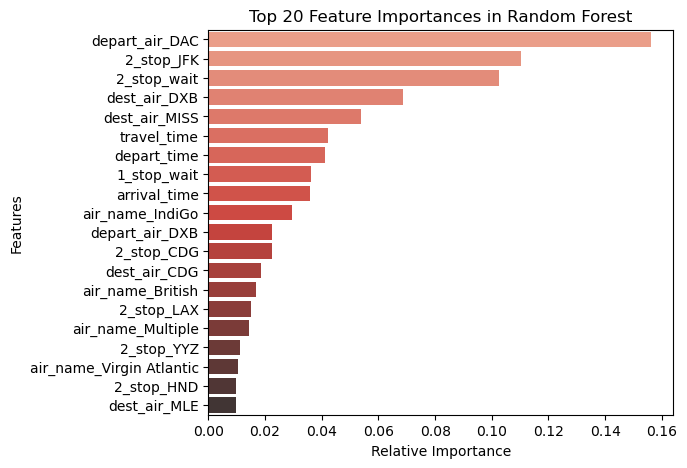

In [ ]:
# plot feature importance
model_name = "Random Forest"
feature_importances = fitted_rf.feature_importances_
feature_names = all_features
num_features_to_display = 20

plot_top_feature_importance(model_name, feature_importances, num_features_to_display, feature_names)

The Random Forest Model identifies 'depart_air_DAC' (the one-hot encoded categorical variable for the departure airport being DAC), '2_stop_JFK' (the one-hot encoded categorical variable for the second stop airport being JFK), and '2_stop_wait' (a numerical variable indicating the wait time at the second stop), 'dest_air_DXB'(the one-hot encoded categorical variable for the destination airport being DXB), 'dest_air_MISS'(the one-hot encoded categorical variable for the destination airport being MISS), and 'travel time' as the most important features. These findings are consistent across various models we have experimented with so far, highlighting a clear trend: the departure and destination airports, the existence of two stops, and travel time, can significantly influence flight ticket prices.

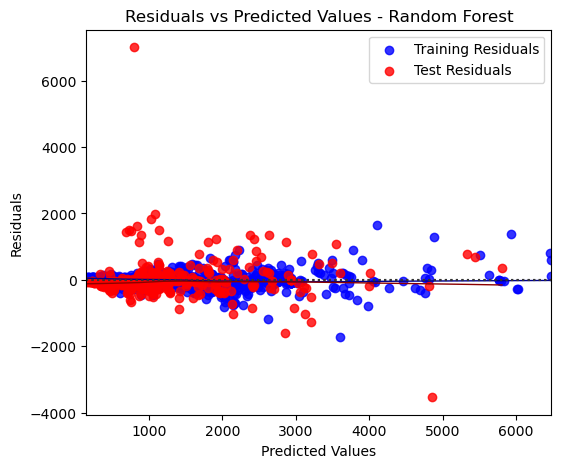

In [ ]:
# Residual Plot
plot_residuals(model = fitted_rf,model_name = "Random Forest", X_train = X_train_prep, y_train = y_train, X_test = X_test_prep, y_test = y_test)

In the training set, the residuals are quite small and exhibit no apparent residual patterns, indicating a good fit of the model to the training data. However, in the case of the testing set, there are some extreme outliers in the residuals. These outliers could be potentially concerning as they may signal the model's limitations in accurately predicting certain scenarios, leading to significant prediction errors.

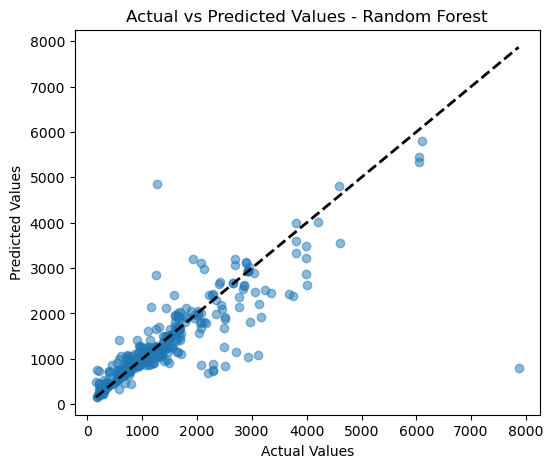

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(fitted_rf,"Random Forest", X_test_prep, y_test)

Utilizing Random Forest Regression, the predicted and actual ticket prices for the testing set generally show good alignment at lower ticket prices. However, the deviation become more prominent as price increases. Also, presence of a few outliers is concerning, as these could lead to significant prediction errors. These observation suggests the need for further analysis and potential refinement of the model to address these anomalies and enhance overall prediction accuracy

## Random Forest Model (with PCA) Training

In [ ]:
# Define the RandomForestRegressor
rf_model2 = RandomForestRegressor(random_state = 1)

# Define the hyperparameter grid
rf_param_grid = {
    'n_estimators': list(range(10, 500, 100)),
    'max_depth': [5, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Hyperparameter Tuning
best_rf_pca, best_rf_pca_params = hyperparameter_tuning(rf_model2, rf_param_grid, X_train_pca_reduced, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 310}


In [ ]:
# Fit and evaluate the model
fitted_rf_pca, rf_pca_train_r2, rf_pca_test_r2, rf_pca_train_mse, rf_pca_test_mse, rf_pca_training_time = fit_and_evaluate_model(best_rf_pca.best_estimator_, X_train_pca_reduced, y_train, X_test_pca_reduced, y_test)

# Print the results
print(f"Random Forest Training R²: {rf_pca_train_r2}")
print(f"Random Forest Test R²: {rf_pca_test_r2}")
print(f"Random Forest Training MSE: {rf_pca_train_mse}")
print(f"Random Forest Test MSE: {rf_pca_test_mse}")

Random Forest Training R²: 0.9644608626972567
Random Forest Test R²: 0.7049462169422431
Random Forest Training MSE: 27065.879313876543
Random Forest Test MSE: 253267.10136028694


## Model Intepretation

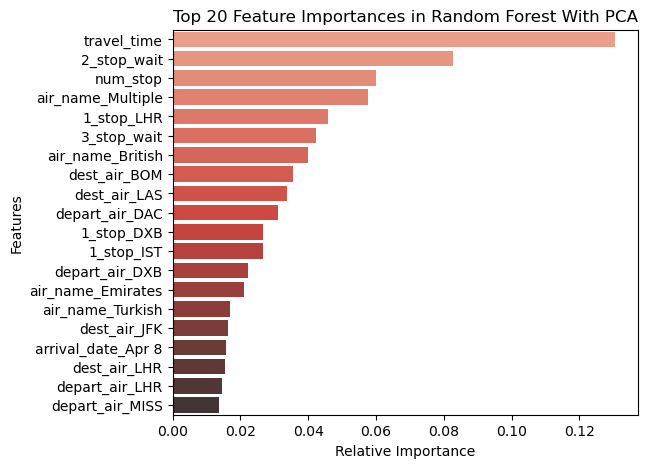

In [ ]:
# revert back to orginal feature and explore importance
pca_reverted_feature_importance = get_original_feature_importances(model = fitted_rf_pca, pca = pca, original_features = all_features, n_components=n_components)
rf_pca_feature_names = [item[0] for item in pca_reverted_feature_importance]
rf_pca_feature_importances = [item[1] for item in  pca_reverted_feature_importance]
plot_top_feature_importance(model_name="Random Forest With PCA", feature_importance = rf_pca_feature_importances, num_features_to_display = 20 , feature_names = rf_pca_feature_names)

The Random Forest Model, augmented with PCA, identifies 'travel time,' '2_stop_wait' (a numerical variable indicating the wait time at the second stop), 'num_stop,' and 'air_name_Multiple' (the one-hot encoded categorical variable for the airline being multiple) as the top three most important features. This finding is in line with the results from other models experimented with so far, underscoring the significant impact of travel time and the presence of two stops on flight ticket pricing. It highlights consistent patterns across different models, emphasizing the influence of journey duration and stopover characteristics on the cost of air travel.

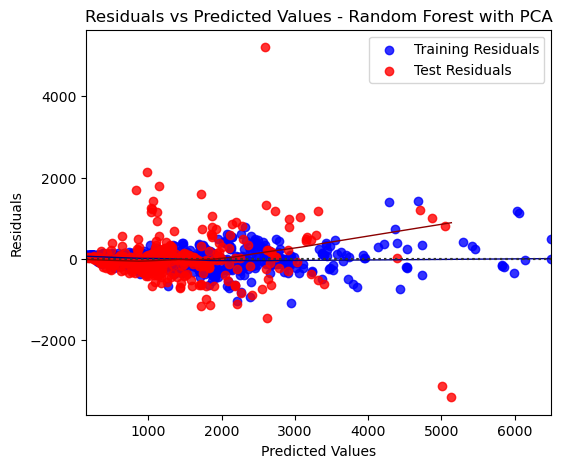

In [ ]:
# Residual Plot
plot_residuals(fitted_rf_pca,"Random Forest with PCA", X_train=X_train_pca_reduced, y_train= y_train, X_test = X_test_pca_reduced, y_test = y_test)

Similar to the observations from the residual plots of the Random Forest model without PCA, the application of PCA with Random Forest presents a similar pattern. In the training set, the residuals are notably small and do not show any discernible patterns, suggesting an effective fit of the model to the training data. However, the testing set tells a different story, with the presence of extreme outliers in the residuals and inconsistent variances across different predicted ticket prices. This inconsistency points to potential limitations of the model in accurately predicting certain scenarios, potentially leading to significant prediction errors.

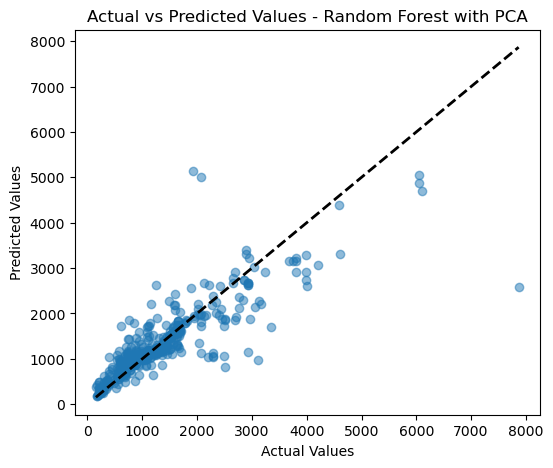

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(fitted_rf_pca,"Random Forest with PCA", X_test_pca_reduced, y_test)

Employing Random Forest Regression with PCA, the alignment between predicted and actual ticket prices in the testing set is quite accurate for lower-priced tickets. However, as ticket prices increase, there is a notable deviation between the predicted and actual values. This divergence, particularly pronounced in the higher price range, suggests limitations in the model's ability to accurately predict more expensive tickets. Additionally, the presence of a few outliers in these predictions is a cause for concern, as they could lead to significant prediction errors. These observations underscore the limitation of the model.

## Summary and Key Takeaways

In [ ]:
# display and compare the results from previous models
model_results_df2 = display_results("Random Forest with PCA", rf_pca_train_r2,rf_pca_test_r2, rf_pca_train_mse, rf_pca_test_mse, rf_pca_training_time, model_results_df)
display(model_results_df2)

,Model,Train_R^2,Test_R^2,Train_MSE,Test_MSE,Training Time
0,Baseline: Multiple Linear Regression,0.713114,-3.281324e+18,218486.564344,2.816610e+24,NaN
1,PCR Ridge,0.452015,4.575104e-01,417334.189564,4.656601e+05,0.001997
2,PCR Lasso,0.451834,4.571908e-01,417471.691608,4.659345e+05,0.001007
3,KNN,0.996680,6.293262e-01,2528.725054,3.181775e+05,0.000998
4,Random Forest,0.965251,6.859960e-01,26464.481284,2.695335e+05,1.679247
5,Random Forest with PCA,0.964461,7.049462e-01,27065.879314,2.532671e+05,12.504883


Utilizing Random Forest and Random Forest with PCA significantly improved model performance compared to the baseline Multiple Linear Regression, as evidenced by more higher testing R² and lower testinng MSE values. Particularly, the Random Forest models showed a notable improvement in Test R² scores, indicating better generalization capabilities than the baseline. The comparison between Random Forest and Random Forest with PCA reveals that PCA slightly enhances the model's ability to generalize, as seen in the higher Test R² score, although at the cost of increased training time. However, both models exhibit potential overfitting, as suggested by the much higher R² scores in training compared to testing. This overfitting, along with the presence of outliers and deviation at higher price ranges, indicates a limitation in these models' capacity to uniformly capture the complexities across the entire data spectrum, especially for higher-priced tickets.

# Model 4: Gradient Boosting Regression

## Motivation for Model Selection:
The next model we decided to experiement with is Gradient Boosting. Boosting is a sequential process where each base learner focuses on correcting the errors made by the previous learners. Misclassified points receive higher weights in subsequent iterations. Its ability to capture complex, non-linear relationships through an ensemble of decision trees makes it well-suited for our datasets where we've seen that linear models has fallen short. Gradient Boosting is particularly adept at improving performance by sequentially focusing on errors, which enhances its robustness against overfitting and makes it effective even with weak predictors. Additionally, its intrinsic feature importance evaluation can address issues arising from high-dimensionality in our data. Unlike linear models, Gradient Boosting does not rely on the homoscedasticity assumption and can handle missing data, offering a more flexible and adaptable approach to modeling the flight dataset's nuances. These qualities make Gradient Boosting a promising alternative to explore, potentially leading to more accurate and insightful predictions for our flight ticket price prediction purposes.



## Gradient Boosting (without PCA) Model Training

In [ ]:
# Define the GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state = 1)

# Define the hyperparameter grid
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6]
}

# Perform Hyperparameter Tuning
best_gb, best_gb_params = hyperparameter_tuning(gb_model, gb_param_grid, X_train_prep, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 300}


In [ ]:
# Fit and Evaluate the Model
fitted_gb, gb_train_r2, gb_test_r2, gb_train_mse, gb_test_mse, gb_training_time = fit_and_evaluate_model(best_gb.best_estimator_, X_train_prep, y_train, X_test_prep, y_test)

# Print the results
print(f"Gradient Boosting Training R²: {gb_train_r2}")
print(f"Gradient Boosting Test R²: {gb_test_r2}")
print(f"Gradient Boosting Training MSE: {gb_train_mse}")
print(f"Gradient Boosting Test MSE: {gb_test_mse}")

Gradient Boosting Training R²: 0.9652420095621267
Gradient Boosting Test R²: 0.7548399111652466
Gradient Boosting Training MSE: 26470.973855399025
Gradient Boosting Test MSE: 210439.5491050325


In [ ]:
# display and compare the results from KNN and baseline model
model_results_df3 = display_results("Gradient Boosting", gb_train_r2, gb_test_r2, gb_train_mse, gb_test_mse,  gb_training_time, model_results_df2)
display(model_results_df3)

,Model,Train_R^2,Test_R^2,Train_MSE,Test_MSE,Training Time
0,Baseline: Multiple Linear Regression,0.713114,-3.281324e+18,218486.564344,2.816610e+24,NaN
1,PCR Ridge,0.452015,4.575104e-01,417334.189564,4.656601e+05,0.001997
2,PCR Lasso,0.451834,4.571908e-01,417471.691608,4.659345e+05,0.001007
3,KNN,0.996680,6.293262e-01,2528.725054,3.181775e+05,0.000998
4,Random Forest,0.965251,6.859960e-01,26464.481284,2.695335e+05,1.679247
5,Random Forest with PCA,0.964461,7.049462e-01,27065.879314,2.532671e+05,12.504883
6,Gradient Boosting,0.965242,7.548399e-01,26470.973855,2.104395e+05,2.125135


## Model Intepretation

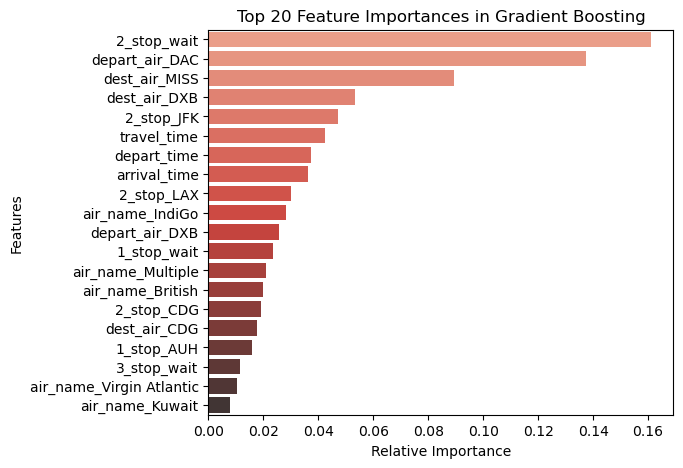

In [ ]:
# plot feature importance
model_name = "Gradient Boosting"
feature_importances = fitted_gb.feature_importances_
num_features_to_display = 20

plot_top_feature_importance(model_name, feature_importances, num_features_to_display, all_features)

The Gradient Boosting Model identifies '2_stop_wait' (a numerical variable indicating the wait time at the second stop), 'depart_air_DAC' (the one-hot encoded categorical variable for the departure airport being DAC),   'dest_air_MISS'(the one-hot encoded categorical variable for the destination airport being MISS), 'dest_air_DXB'(the one-hot encoded categorical variable for the destination airport being DXB), and '2_stop_JFK' (the one-hot encoded categorical variable for the second stop airport being JFK) and 'travel time' as the most important features. These findings are consistent especially with the result of Random Forest without PCA. Similiar to the previous models we have experimented with so far, this indicates a clear trend that the departure and destination airports, the existence of two stops, and travel time, significantly influence flight ticket prices.

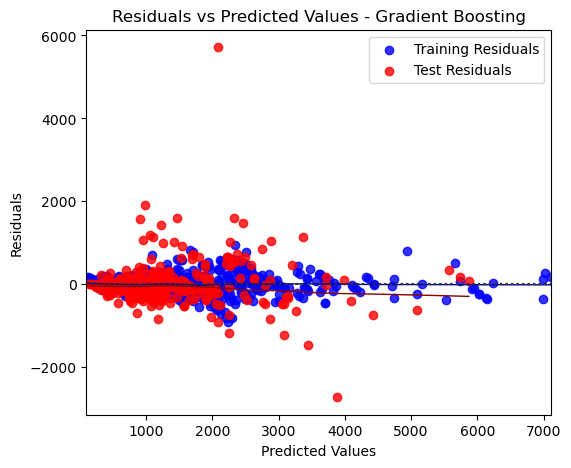

In [ ]:
# Residual Plot
plot_residuals(fitted_gb,"Gradient Boosting", X_train=X_train_prep, y_train= y_train, X_test = X_test_prep, y_test = y_test)

In the training set, we observe that the residuals are notably small and lack any discernible patterns, suggesting that the model fits the training data well. However, the testing set presents a different scenario, characterized by some extreme outliers in the residuals. These outliers are a potential cause for concern, as they might indicate the model's limitations in accurately predicting certain scenarios.

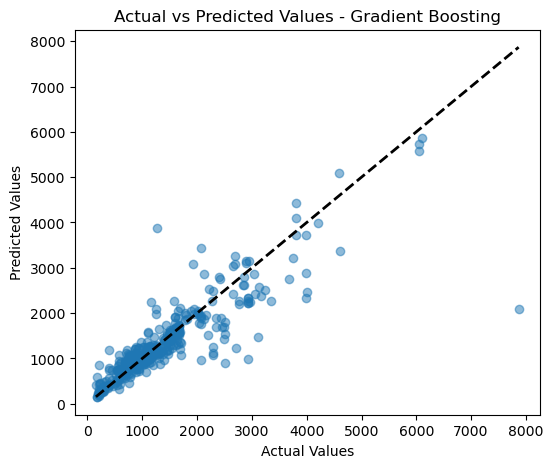

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(fitted_gb,"Gradient Boosting", X_test_prep, y_test)

In the testing set, the Gradient Boosting Regression model generally demonstrates a good alignment between the predicted and actual ticket prices. However, the occurrence of a few outliers is a point of concern. These outliers could result in significant prediction errors and imply that the model may not be capturing certain aspects of the data effectively. This situation suggests a need for additional analysis and possible refinement of the model.

## Gradient Boosting Regression (With PCA) Training

In [ ]:
# Define the RandomForestRegressor
gb_model2 = GradientBoostingRegressor(random_state = 1)

# Define the hyperparameter grid
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6]
}

# Perform Hyperparameter Tuning
best_gb_pca, best_gb_pca_params = hyperparameter_tuning(gb_model2, gb_param_grid, X_train_pca_reduced, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 300}


In [ ]:
# Fit and evaluate the model
fitted_gb_pca, gb_pca_train_r2, gb_pca_test_r2, gb_pca_train_mse, gb_pca_test_mse, gb_pca_training_time = fit_and_evaluate_model(best_gb_pca.best_estimator_, X_train_pca_reduced, y_train, X_test_pca_reduced, y_test)

# Print the results
print(f"Gradient Boosting R²: {gb_pca_train_r2}")
print(f"Gradient Boosting R²: {gb_pca_test_r2}")
print(f"Gradient Boosting MSE: {gb_pca_train_mse}")
print(f"Gradient Boosting MSE: {gb_pca_test_mse}")

Gradient Boosting R²: 0.9905963212763614
Gradient Boosting R²: 0.6451379796505061
Gradient Boosting MSE: 7161.649177703125
Gradient Boosting MSE: 304605.0599499631


## Model Intepretation

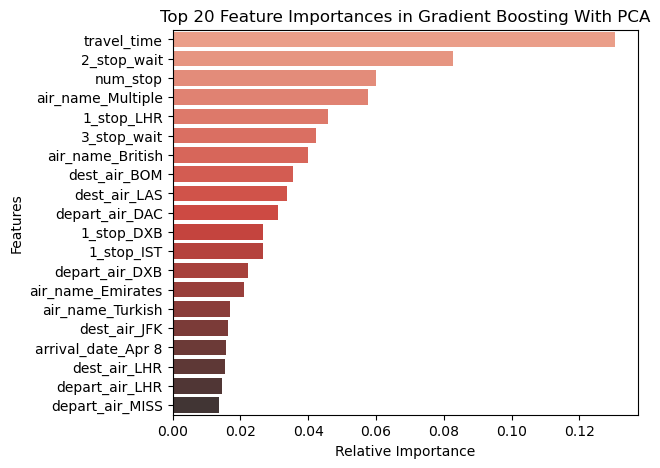

In [ ]:
# revert back to orginal feature and explore importance
pca_reverted_feature_importance2 = get_original_feature_importances(model = fitted_gb_pca, pca = pca, original_features = all_features, n_components=n_components)
gb_pca_feature_names = [item[0] for item in pca_reverted_feature_importance]
gb_pca_feature_importances = [item[1] for item in  pca_reverted_feature_importance]
plot_top_feature_importance(model_name="Gradient Boosting With PCA", feature_importance= gb_pca_feature_importances, num_features_to_display = 20 , feature_names = gb_pca_feature_names )

The Gradient Boosting Regression model, when combined with PCA, highlights 'travel time,' '2_stop_wait' (a numerical variable for the wait time at the second stop), 'num_stop', and 'air_name_Multiple' (the one-hot encoded categorical variable representing multiple airlines) as the top most influential features. This aligns closely with the findings from the Random Forest Regression model with PCA, further emphasizing the significant role of travel time and the presence of two stops in determining flight ticket prices. The consistency of these results across different models reinforces the understanding that both journey duration and stopover details are crucial factors influencing airfare.

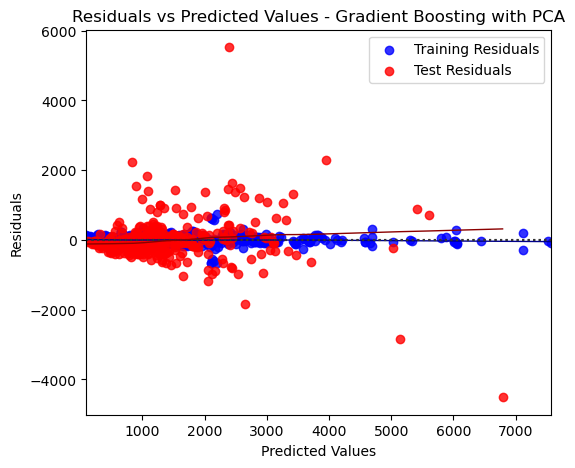

In [ ]:
# Residual Plot
plot_residuals(fitted_gb_pca,"Gradient Boosting with PCA", X_train=X_train_pca_reduced, y_train= y_train, X_test = X_test_pca_reduced, y_test = y_test)

For Gradient Boosting With PCA, in the training set, the residuals are notably small and do not show any leftover patterns, suggesting a good fit of the model to the training data. However, for the testing sets, there are extreme outliers in the residuals and inconsistent variances across different predicted ticket prices. This could lead to significant prediction errors.

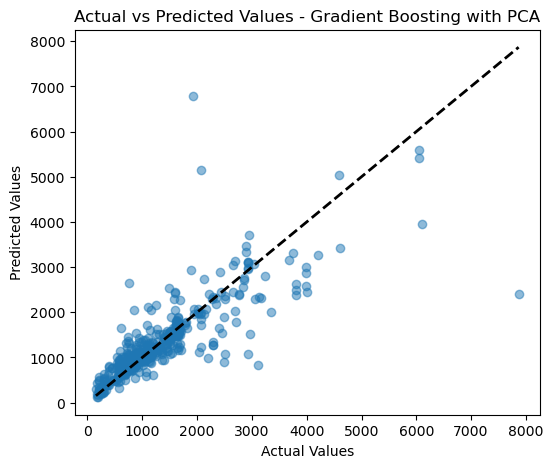

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(fitted_gb_pca,"Gradient Boosting with PCA", X_test_pca_reduced, y_test)

Using Gradient Boosting with PCA, the alignment between predicted and actual ticket prices in the testing set is again quite accurate for lower-priced tickets. However, as ticket prices increase, there is a notable deviation between the predicted and actual values. This also suggests limitations in the model's ability to accurately predict more expensive tickets. Additionally, the presence of a few outliers in these predictions is a cause for concern, as they could lead to significant prediction errors.

## Summary and Key Takeaways

In [ ]:
model_results_df4 = display_results("Gradient Boosting with PCA", gb_pca_train_r2,gb_pca_test_r2, gb_pca_train_mse, gb_pca_test_mse, gb_pca_training_time, model_results_df3)
display(model_results_df4)

,Model,Train_R^2,Test_R^2,Train_MSE,Test_MSE,Training Time
0,Baseline: Multiple Linear Regression,0.713114,-3.281324e+18,218486.564344,2.816610e+24,NaN
1,PCR Ridge,0.452015,4.575104e-01,417334.189564,4.656601e+05,0.001997
2,PCR Lasso,0.451834,4.571908e-01,417471.691608,4.659345e+05,0.001007
3,KNN,0.996680,6.293262e-01,2528.725054,3.181775e+05,0.000998
4,Random Forest,0.965251,6.859960e-01,26464.481284,2.695335e+05,1.679247
5,Random Forest with PCA,0.964461,7.049462e-01,27065.879314,2.532671e+05,12.504883
6,Gradient Boosting,0.965242,7.548399e-01,26470.973855,2.104395e+05,2.125135
7,Gradient Boosting with PCA,0.990596,6.451380e-01,7161.649178,3.046051e+05,8.289246


The Gradient Boosting models, both with and without PCA, show marked improvements over the baseline Multiple Linear Regression in test R² and MSE scores, reflecting better predictive accuracy and generalization. Interestingly, standard Gradient Boosting outperforms the PCA-augmented version, achieving a higher test R² and a lower test MSE, despite the high dimensionality of the data. This suggests Gradient Boosting's inherent robustness to high-dimensional spaces, diminishing the utility of PCA in this context. Furthermore, the decision to use only the first 30 principal components, which explain 90% of the variance, could also have influenced the performance of the PCA-enhanced model. This limitation in the number of components might have led to the loss of critical information, contributing to the observed overfitting in the training phase and reduced efficacy on the test data.
In terms of limitations, both versions of Gradient Boosting, particularly the PCA version, demonstrate potential shortcomings in accurately capturing complex data relationships, as evidenced by the presence of outliers and inconsistent residual variance, with the PCA model also incurring additional computational time.

# Model 5: Support Vector Regression (Without PCA)

## Motivation for Model Selection:
The final model we chose to experiment with is Support Vector Regression (SVR). SVR, a variant of the Support Vector Machine (SVM), seeks to establish a hyperplane that optimally represents the relationship between predictors and the response variable while minimizing prediction error. It utilizes support vectors, data points nearest to the hyperplane, to define a margin, ensuring predicted values fall within an acceptable error range. A key strength of SVR is its capability to manage non-linear relationships via various kernel functions, making it well-suited for complex datasets, such as ours, where linear models are inadequate. Its robustness against overfitting is particularly valuable, addressing a key issue we observed with our baseline model. Furthermore, SVR's efficiency in handling high-dimensional, heterogeneous, and sparse data, coupled with its focus on margin maximization, enhances its resilience to outliers – a feature evident in our data from baseline model analyses and exploratory data analysis (EDA). Its balanced approach to regression tasks positions SVR as a promising option to more accurately capture the nuances and complexities within our flight dataset, potentially improving overall model performance


## Steps of Support Vector Regression (SVR)

### 1. Select a Kernel and Parameters
Choose an appropriate kernel based on the data:
- Linear: $K(x_i, x_j) = x_i \cdot x_j$
- Polynomial: $K(x_i, x_j) = (1 + x_i \cdot x_j)^d$
- Radial Basis Function (RBF): $K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$
- Sigmoid: $K(x_i, x_j) = \tanh(\gamma x_i \cdot x_j + r)$

Tune parameters such as $\gamma$ in RBF and degree $d$ in the polynomial kernel.

### 2. Choose a Value for C
Determine the regularization parameter $C$. It controls the trade-off between the flatness of the regression function and the amount up to which deviations larger than $\epsilon$ are tolerated.

### 3. Formulate the Lagrangian Problem with Constraints
For a given set of training data $(x_i, y_i)$, the optimization problem is to minimize:
$$ \frac{1}{2}\|w\|^2 + C\sum_{i=1}^n (\xi_i + \xi_i^*) $$

Subject to the constraints:
- $y_i - (wx_i + b) \leq \epsilon + \xi_i$
- $(wx_i + b) - y_i \leq \epsilon + \xi_i^*$
- $\xi_i, \xi_i^* \geq 0$

$$$$
The constraints exist to ensure that the predictions $(wx_i + b)$ are within the epsilon ($\epsilon$) margin of the actual values ($y_i$). The slack variables $\xi_i$ and $\xi_i^*$ quantify the excess deviation from the margin, after which they are used for penalizing the model through the term $C\sum_{i=1}^n (\xi_i + \xi_i^*)$.

### 4. Solve for Lagrange Multipliers
Introduce Lagrange multipliers $\alpha_i, \alpha_i^*$ for each constraint and solve the dual problem. The dual problem is typically easier to solve and especially beneficial when using non-linear kernels.

### 5. Construct the Regression Function
After solving for the Lagrange multipliers, construct the regression function. For non-linear kernels, it incorporates the kernel function:
$$ f(x) = \sum_{i=1}^n (\alpha_i - \alpha_i^*) K(x_i, x) + b $$

Where $x_i$ are support vectors, and $\alpha_i, \alpha_i^*$ are the non-zero Lagrange multipliers.

### GridSearchCV

We determine the best hyperparameters involved in these steps (such as kernel, gamma, C, epsilon) by using the same method that was applied to our previous models, which is GridSearchCV.


## Support Vector Machine Regression Model Training

In [ ]:
# Define the SVM Regressor
svm_model = SVR()

# Define the hyperparameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.2]
}

# Perform Hyperparameter Tuning
best_svm, best_svm_params = hyperparameter_tuning(svm_model, svm_param_grid, X_train_prep, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
# Fit and Evaluate the Model
fitted_svm, svm_train_r2, svm_test_r2, svm_train_mse, svm_test_mse, svm_training_time = fit_and_evaluate_model(best_svm.best_estimator_, X_train_prep, y_train, X_test_prep, y_test)

# Print the results
print(f"SVM Training R²: {svm_train_r2}")
print(f"SVM Test R²: {svm_test_r2}")
print(f"SVM Training MSE: {svm_train_mse}")
print(f"SVM: {svm_test_mse}")

SVM Training R²: 0.37971617571010297
SVM Test R²: 0.3217675021859233
SVM Training MSE: 472395.46040652564
SVM: 582178.5336542983


In [ ]:
# display and compare the results from KNN and baseline model
model_results_df5 = display_results("SVM", svm_train_r2, svm_test_r2, svm_train_mse, svm_test_mse, svm_training_time,model_results_df4)
display(model_results_df5)

,Model,Train_R^2,Test_R^2,Train_MSE,Test_MSE,Training Time
0,Baseline: Multiple Linear Regression,0.713114,-3.281324e+18,218486.564344,2.816610e+24,NaN
1,PCR Ridge,0.452015,4.575104e-01,417334.189564,4.656601e+05,0.001997
2,PCR Lasso,0.451834,4.571908e-01,417471.691608,4.659345e+05,0.001007
3,KNN,0.996680,6.293262e-01,2528.725054,3.181775e+05,0.000998
4,Random Forest,0.965251,6.859960e-01,26464.481284,2.695335e+05,1.679247
5,Random Forest with PCA,0.964461,7.049462e-01,27065.879314,2.532671e+05,12.504883
6,Gradient Boosting,0.965242,7.548399e-01,26470.973855,2.104395e+05,2.125135
7,Gradient Boosting with PCA,0.990596,6.451380e-01,7161.649178,3.046051e+05,8.289246
8,SVM,0.379716,3.217675e-01,472395.460407,5.821785e+05,0.142487


## Model Intepretation

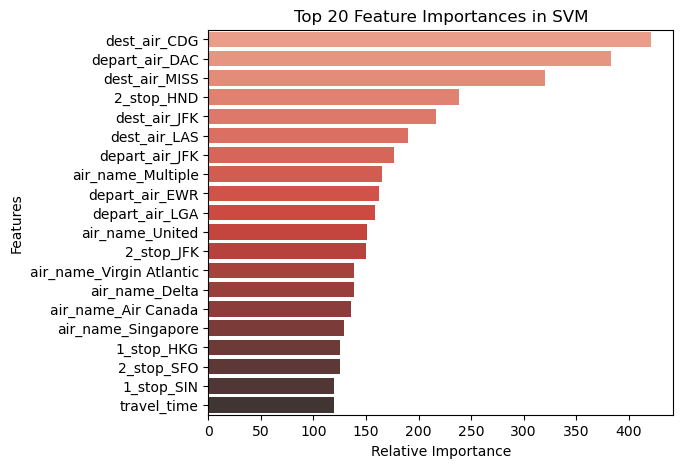

In [ ]:
# plot feature importance
model_name = "SVM"
feature_importances = fitted_svm.coef_.flatten()
num_features_to_display = 20

plot_top_feature_importance(model_name, feature_importances, num_features_to_display, all_features)

First of all, we noticed that the gridcv happens to select linear kernal as best kernal, which allows us to get the feature importance for SVR.

The Support Vector Regression identifies 'dest_air_CDG' (the one-hot encoded categorical variable for the destination airport being CDG), 'depart_air_DAC', 'dest_air_MISS', '2_stop_HND' and 'dest_air_JFK' as the most important features. These findings are consistent across various models we have experimented with so far, highlighting a clear trend: the departure and destination airports, and the existence of two stops can  significantly influence flight ticket prices.

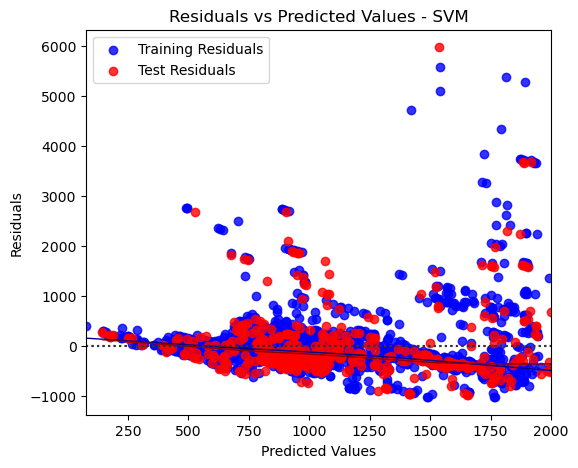

In [ ]:
# Residual Plot
plot_residuals(fitted_svm,"SVM", X_train=X_train_prep, y_train= y_train, X_test = X_test_prep, y_test = y_test)

In the SVM regression model, the residuals for both the training and testing sets appear to exhibit a trend where their magnitude increases with the predicted ticket prices. This pattern suggests a possible heteroscedasticity in the model, where prediction errors are not consistent across all levels of ticket prices. Particularly, the model seems less accurate for higher-priced tickets, indicating a limitation in its ability to handle data with varying scales or more complex scenarios. Such an increase in residual magnitude at higher ticket prices could also imply that the model's assumptions or the selected kernel function may not fully capture the underlying relationship for more expensive tickets. This observation points to the need for further investigation into feature interactions or considering alternative modeling approaches or that might better accommodate the variability across the range of ticket prices

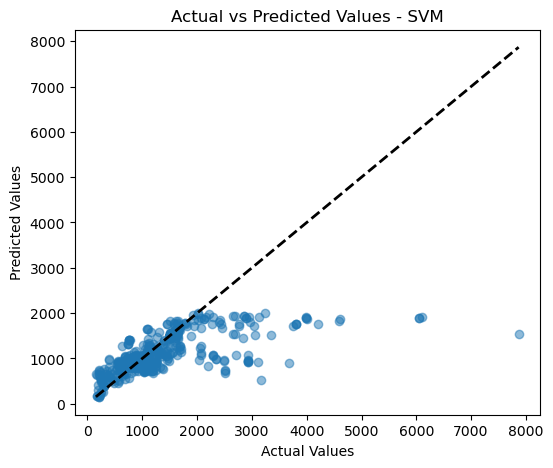

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(fitted_svm,"SVM", X_test_prep, y_test)

As anticipated, the alignment between predicted and actual ticket prices for the testing sets in the SVM model using a linear kernel is not particularly strong, especially at higher price ranges. This discrepancy is more pronounced with increasing ticket prices, suggesting that the linear kernel may not adequately capture the complexity of the data in these ranges. The model's inability to accurately predict higher-priced tickets likely reflects a limitation in the linear approach to handling non-linear patterns or interactions within the data.

## Support Vector Regression Training (With PCA)

In [ ]:
# Define the SVM Regressor
svm_pca_model = SVR()

# Define the hyperparameter grid
svm_pca_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.2]
}

# Perform Hyperparameter Tuning
best_svm_pca, best_svm_pca_params = hyperparameter_tuning(svm_pca_model, svm_pca_param_grid, X_train_pca_reduced, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'C': 10, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
fitted_svm_pca, svm_pca_train_r2, svm_pca_test_r2, svm_pca_train_mse, svm_pca_test_mse, svm_pca_training_time = fit_and_evaluate_model(best_svm_pca.best_estimator_, X_train_pca_reduced, y_train, X_test_pca_reduced, y_test)

# Print the results
print(f"SVM with PCA Training R²: {svm_pca_train_r2}")
print(f"SVM with PCA Test R²: {svm_pca_test_r2}")
print(f"SVM with PCA Training MSE: {svm_pca_train_mse}")
print(f"SVM with PCA : {svm_pca_test_mse}")

SVM with PCA Training R²: 0.3309208407911327
SVM with PCA Test R²: 0.29257443489781065
SVM with PCA Training MSE: 509556.9884072374
SVM with PCA : 607237.1634920619


## Model Intepretation

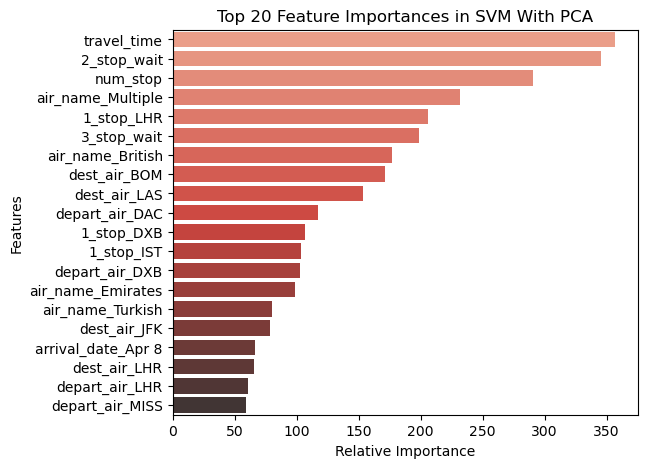

In [ ]:
# revert back to orginal feature and explore importance
svm_pca_reverted_feature_importance = get_original_feature_importances(model = fitted_svm_pca, pca = pca, original_features = all_features, n_components=n_components)
svm_pca_feature_names = [item[0] for item in svm_pca_reverted_feature_importance]
svm_pca_feature_importances = [item[1] for item in  svm_pca_reverted_feature_importance]
plot_top_feature_importance(model_name="SVM With PCA", feature_importance= svm_pca_feature_importances, num_features_to_display = 20 , feature_names = gb_pca_feature_names )

First of all, we noticed that the gridsearchcv happens to select linear kernal as best kernal, which allows us to cover the feature importance for SVR

The Support Vector Regression model, when combined with PCA, highlights 'travel time,' '2_stop_wait' (a numerical variable for the wait time at the second stop), 'num_stop', and 'air_name_Multiple' (the one-hot encoded categorical variable representing multiple airlines) as the top most influential features. This aligns closely with the findings from the Random Forest Regression model with PCA and Gradient Boosting with PCA, further emphasizing the significant role of travel time and the presence of two stops in determining flight ticket prices.

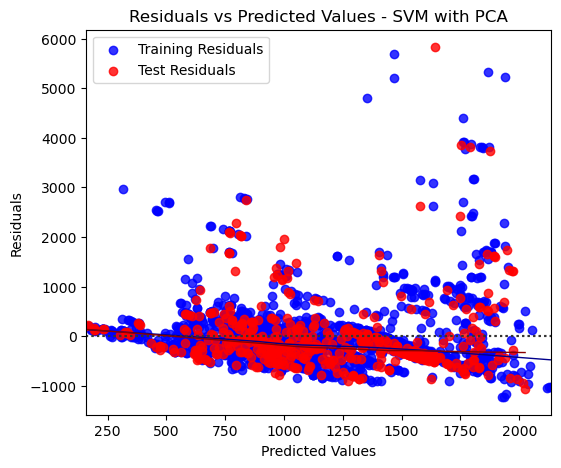

In [ ]:
# Residual Plot
plot_residuals(fitted_svm_pca,"SVM with PCA", X_train=X_train_pca_reduced, y_train= y_train, X_test = X_test_pca_reduced, y_test = y_test)

Similar to the residual plot of Support Vector Regression without PCA, we observe a notable trend in both training and testing sets: the magnitude of the residuals increases with the predicted ticket prices. This pattern indicates potential heteroscedasticity within the model, suggesting that prediction errors are not uniform across different ticket price levels. The model's decreased accuracy for higher-priced tickets highlights its limitations in handling data of varying scales or addressing more complex scenarios, and suggests the need for additional refinement and possibly exploring alternative strategies to improve the model's performance.

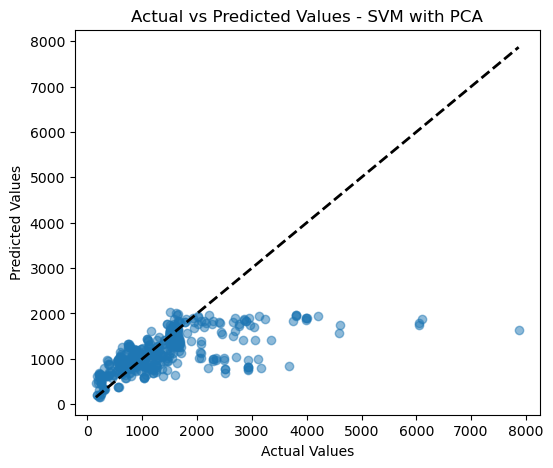

In [ ]:
# Prediction vs Actual Plot
plot_predictions_vs_actual(fitted_svm_pca,"SVM with PCA", X_test_pca_reduced, y_test)

the alignment between predicted and actual prices in the Support Vector Regression model with PCA is quite poor, with a noticeable deviation particularly at higher price ranges

## Summary and Key Takeaways

In [ ]:
# display and compare the results from KNN and baseline model
model_results_df6 = display_results("SVM with PCA", svm_pca_train_r2, svm_pca_test_r2, svm_pca_train_mse, svm_pca_test_mse, svm_pca_training_time,model_results_df5)
display(model_results_df6)

,Model,Train_R^2,Test_R^2,Train_MSE,Test_MSE,Training Time
0,Baseline: Multiple Linear Regression,0.713114,-3.281324e+18,218486.564344,2.816610e+24,NaN
1,PCR Ridge,0.452015,4.575104e-01,417334.189564,4.656601e+05,0.001997
2,PCR Lasso,0.451834,4.571908e-01,417471.691608,4.659345e+05,0.001007
3,KNN,0.996680,6.293262e-01,2528.725054,3.181775e+05,0.000998
4,Random Forest,0.965251,6.859960e-01,26464.481284,2.695335e+05,1.679247
5,Random Forest with PCA,0.964461,7.049462e-01,27065.879314,2.532671e+05,12.504883
6,Gradient Boosting,0.965242,7.548399e-01,26470.973855,2.104395e+05,2.125135
7,Gradient Boosting with PCA,0.990596,6.451380e-01,7161.649178,3.046051e+05,8.289246
8,SVM,0.379716,3.217675e-01,472395.460407,5.821785e+05,0.142487
9,SVM with PCA,0.330921,2.925744e-01,509556.988407,6.072372e+05,0.081669


The Support Vector Regression (SVR) models, both standard and with PCA, exhibit an improvement in test R² scores over the baseline Multiple Linear Regression, indicating a better generalization capability.

However, their performance is significantly worse by more sophisticated models like Random Forest and Gradient Boosting, highlighted by SVR's lower R² and higher MSE.

This underperformance, particularly in the PCA-enhanced SVR, can be attributed to SVR's fundamental mechanism. SVR aims to fit a hyperplane in a high-dimensional space with a minimal margin of error, relying on  support vectors—data points critical in defining the hyperplane's position and orientation—and a margin of tolerance (ε) surrounding the hyperplane. SVR incorporates the 'kernel trick' to efficiently handle non-linear relationships by transforming data into a higher-dimensional space, making it easier to fit a hyperplane. Additionally, SVR employs a regularization parameter (C) to balance between fitting the training data closely and maintaining a wider margin, alongside the epsilon parameter that determines the margin width.

The mechanism of SVR, especially with the chosen linear kernel by the gridsearchCV, may be too simplistic to capture the data's complex, non-linear relationships, leading to a potential underfitting issue. This is exacerbated in the PCA version, where dimensionality reduction might contribute to information loss, further obscuring crucial relationships in the data.

Additionally, SVR's performance is highly sensitive to hyperparameter choices, particularly the regularization parameter 'C' and epsilon. These parameters, if not optimally tuned, can significantly affect the model's ability to fit and generalize, contributing to underperformance.

Overall, while SVR shows some advancement over the baseline model, its linear approach, potential underfitting, and critical dependency on hyperparameter tuning, along with the limited benefits of PCA in this context, hinder its efficacy compared to more robust models.







# Final Discussions

## Analysis of Advanced Models

### Comparison of different models

Analyzing the five models, there are distinct differences in performance. The baseline Multiple Linear Regression shows a significantly negative Test R² score, indicating poor generalization likely due to overfitting, as suggested by its reasonable Train R² score. PCR Ridge and PCR Lasso offer modest improvements in Test R² scores but remain limited in capturing complex data patterns. KNN, while demonstrating an excellent fit on the training data (high Train R²), fails to generalize effectively to the test data, indicative of overfitting. Random Forest and Gradient Boosting models, both being ensemble methods, exhibit strong performance with high Train and Test R² scores, indicating their robustness and good generalization capabilities. Notably, Gradient Boosting without PCA outperforms all other models in Test R², affirming its superior ability to handle diverse data complexities. While incorporating PCA into Random Forest improve its performances bosth test R^2 MSE, incorporating PCA Gradient Boosting leads to a decrease in Test R² scores and higher MSE score, suggesting that PCA might not be adding value and could even be detrimental due to potential information loss for the reasons discussed in the above sections.



### Best Model Discussions

Gradient Boosting without PCA emerges as the best model in our analysis. Its highest Test R² score illustrates excellent generalization, effectively capturing the nuances of the dataset and accurately predicting on unseen data. This model benefits from the strengths of Gradient Boosting - handling complex and non-linear data patterns effectively, robustness against overfitting, and adaptability to various data scenarios. Unlike its PCA version, it retains all original features, allowing it to utilize the full scope of the data without the risk of losing crucial information through dimensionality reduction.


Despite its effectiveness, Gradient Boosting without PCA is not without limitations. The R² score of approximately 75.48% for Gradient Boosting without PCA, while respectable, indicates room for improvement. Factors such as data complexity, noise, feature limitations, the need for optimal tuning, and intrinsic model constraints could all contribute to the model not fully capturing the data's variance. It underscores the importance of comprehensive data exploration, feature engineering, careful model tuning, and potentially considering alternative or additional modeling approaches to enhance predictive performance. In addition, its complexity, stemming from an ensemble of decision trees, can result in longer training times and increased computational demand.

##  Future Work/ Scope of improvement

As we look to build upon our current analysis, we're planning several key steps to enhance our predictive models for flight ticket pricing. Firstly, we intend to expand our dataset. By incorporating a larger and more diverse set of data, we aim to capture a broader spectrum of influencing factors and trends. This expansion will not only improve the robustness of our models but also allow us to explore subtler patterns that might be present in larger datasets.

Another critical step is the addition of more relevant features. We believe that integrating specific factors, such as seasonal variations, major events, and economic indicators, could significantly sharpen our models' predictive accuracy. These features are likely to have a direct impact on flight ticket prices, and their inclusion should provide a more nuanced understanding of price fluctuations.


Additional, experimenting with more complex models is on our agenda. While our current models have yielded promising results, there's potential to uncover deeper insights with more advanced machine learning techniques, including deep learning. These sophisticated models might be capable of capturing complex interactions and patterns that simpler models may overlook. However, we'll approach this step with a balanced view, mindful of the challenges such as interpretability and computational demands.

Lastly, in terms of interpretability of models, we also plan to implement permutation importance across all our models as an alternative approach to assess feature significance. This model-agnostic method will enable us to evaluate the impact of each feature on the models' predictions, offering a clearer perspective on which variables are most influential, irrespective of the model used. This insight is invaluable as it guides us in refining our feature selection and engineering strategies.

In summary, these steps are geared towards not only enhancing the accuracy and reliability of our predictive models but also deepening our understanding of the various factors that influence flight ticket pricing. Each step is designed to build on our existing work, pushing the boundaries of our analysis to achieve more refined and insightful results